**Import libraries**

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from matplotlib.pyplot import figure
import plotly.graph_objects as go
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import tensorflow.random
import os
import random
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

pd.options.mode.chained_assignment = None 

**Parsing the input dataset**

In [3]:
df=pd.read_csv("../nasdaq2007_17.csv", delimiter='\t', header=None)
df = df.T
rows_df = df.shape[1]

**Make new column with date**

In [4]:
max_column = len(df.index)
new_col = [x for x in range(0, max_column)]
df.insert(loc=0, column='Date', value=new_col)

**Read number to detect anomalies and number of threshold**

In [5]:
print("Enter the desired number of time series to be predicted for anomalies: ")
while True:
    try:
        n_predict = int(input())
    except ValueError:
        print("Enter valid integer number. Try again")
        continue
    if 1 <= n_predict <= rows_df:
        break
    else:
        print(f"Valid range: Enter 0 - {rows_df}")
        
print("Enter the desired number for mean absolute error (threshold): ")
while True:      
    try:
        threshold = float(input())
    except ValueError:
        print("Enter valid float number. Try again")
        continue
    if 0 < threshold <= 5:
        break
    else:
        print(f"Valid range: Enter 0 - 5")

Enter the desired number of time series to be predicted for anomalies


 30
 0.5


**Choose n random timeseries for forecast**

In [6]:
anomalies_list =  []
anomalies_list = random.sample(range(0, rows_df), n_predict)

print(anomalies_list)

[232, 201, 124, 318, 310, 71, 279, 323, 35, 249, 159, 31, 349, 242, 3, 122, 228, 245, 219, 315, 330, 278, 203, 301, 153, 299, 143, 166, 86, 270]


**Number of timeseries for training**

In [7]:
n_training = rows_df

**Preprocessing dataset**

In [8]:
len_dataframe = len(df.index)
first_80_percent =  math.floor(len_dataframe * 80/100)
last_20_percent = len_dataframe - first_80_percent

training_set_list = []
testing_set_list = []
for i in range (1, n_training+1):
    temp_training_set = []
    temp_testing_set = []
    temp_training_set = df.iloc[1:first_80_percent, i].values #to idio me katw alla ana grammi
    temp_testing_set = df.iloc[first_80_percent:, i].values
    training_set_list.append(list(temp_training_set)) #etsi exoume kathe metoxi ksexwrista!
    testing_set_list.append(list(temp_testing_set))

**Concatenate training set and scaling**

In [9]:
TIME_STEPS=30
X_train = []
y_train = []
X_test = []
y_test = []
scaler = []

for k in range(0, n_training):

    scaler.append(StandardScaler())

    temp_train=np.array(training_set_list[k])
    temp_train=temp_train.reshape(-1,1)
    scaler[k] = scaler[k].fit(temp_train)
    training_set_list[k] = scaler[k].transform(temp_train)

    def create_sequences(X, y, time_steps=TIME_STEPS):
        Xs, ys = [], []
        for i in range(0, len(X)-time_steps):
            Xs.append(X[i:(i+time_steps)])
            ys.append(y[i+time_steps])
        
        return np.array(Xs), np.array(ys)

    tmp_x1, tmp_y1 = create_sequences(training_set_list[k], training_set_list[k])

    X_train.append(tmp_x1)
    y_train.append(tmp_y1)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = X_train.reshape(n_training*2889, TIME_STEPS, 1)
y_train = y_train.reshape(n_training*2889)

**Construct the model**

In [10]:
flag_saved_model = True;

if flag_saved_model == False:
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(rate=0.2))

    model.add(TimeDistributed(Dense(X_train.shape[2])))
    model.compile(optimizer='adam', loss='mae')
    model.summary()

**Fit model or load saved model**

In [11]:
if flag_saved_model == False:
    
    keras.backend.clear_session()
    history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, shuffle=False)
    name = 'my_model_B.h5'
    print(name)
    model.save(name)
    
else:
    # Recreate the exact same model, including its weights and the optimizer
    name = 'pre_trained_models/model_B.h5'
    model = tf.keras.models.load_model(name)

**Plot training loss and validation loss**

In [12]:
if flag_saved_model == False:
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend();

**Processing test set and detecting anomalies**

22/22 [==============================] - 2s 5ms/step - loss: 0.1563
0.15629562735557556


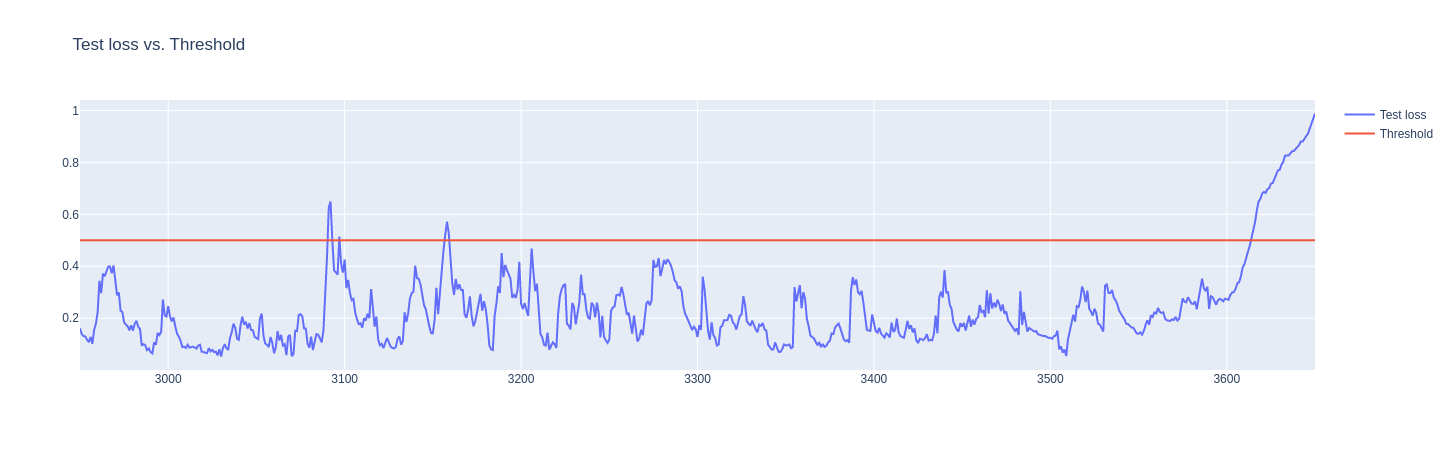

(44, 5)


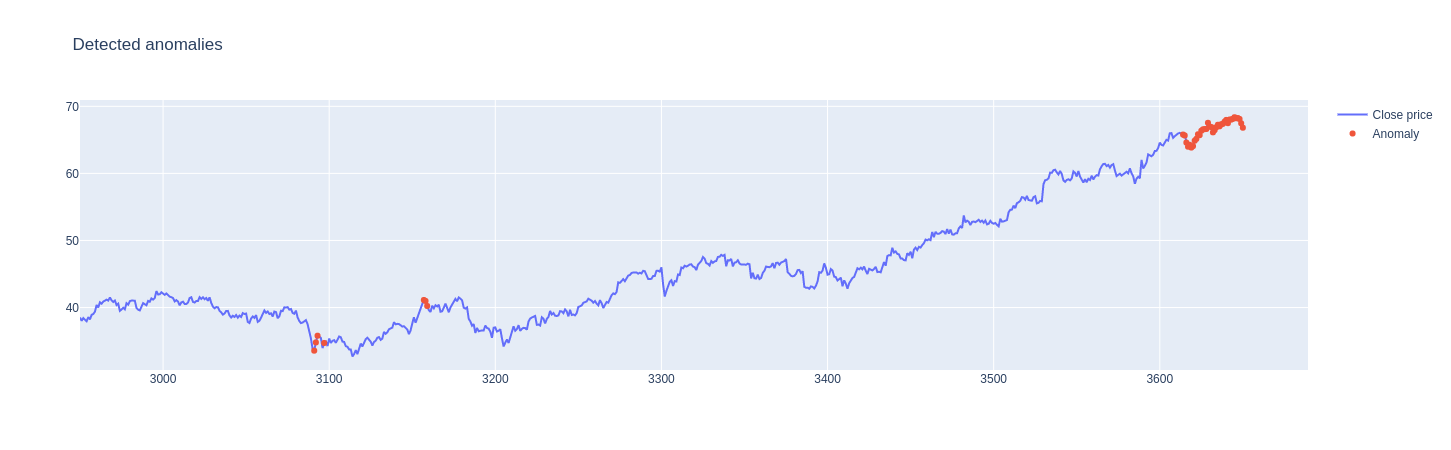

22/22 [==============================] - 0s 5ms/step - loss: 0.0795
0.07950025796890259


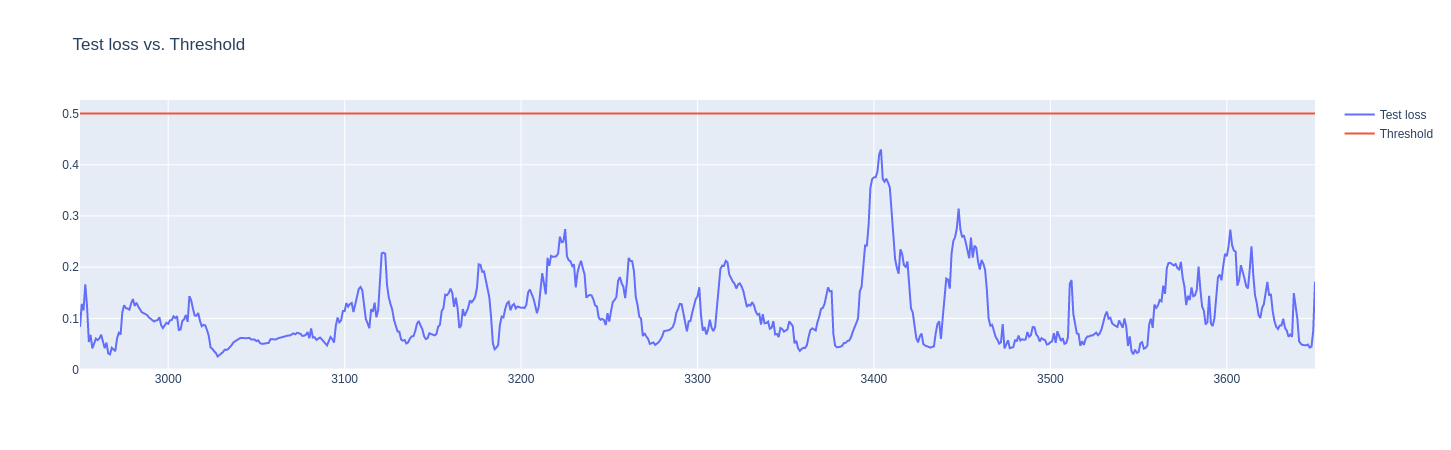

(0, 5)


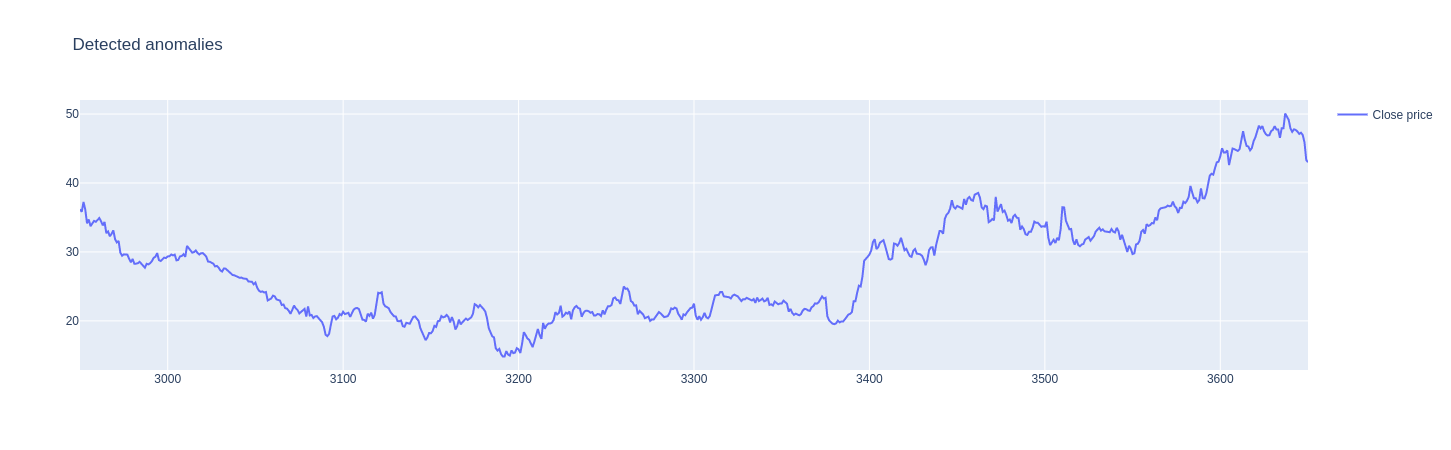

22/22 [==============================] - 0s 5ms/step - loss: 0.0792
0.07915345579385757


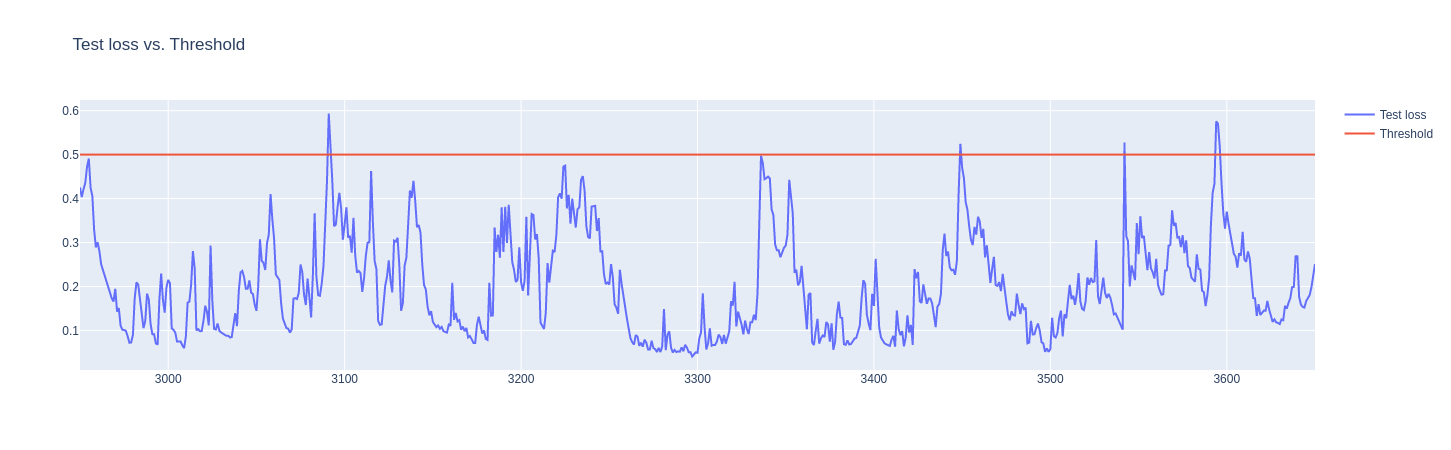

(7, 5)


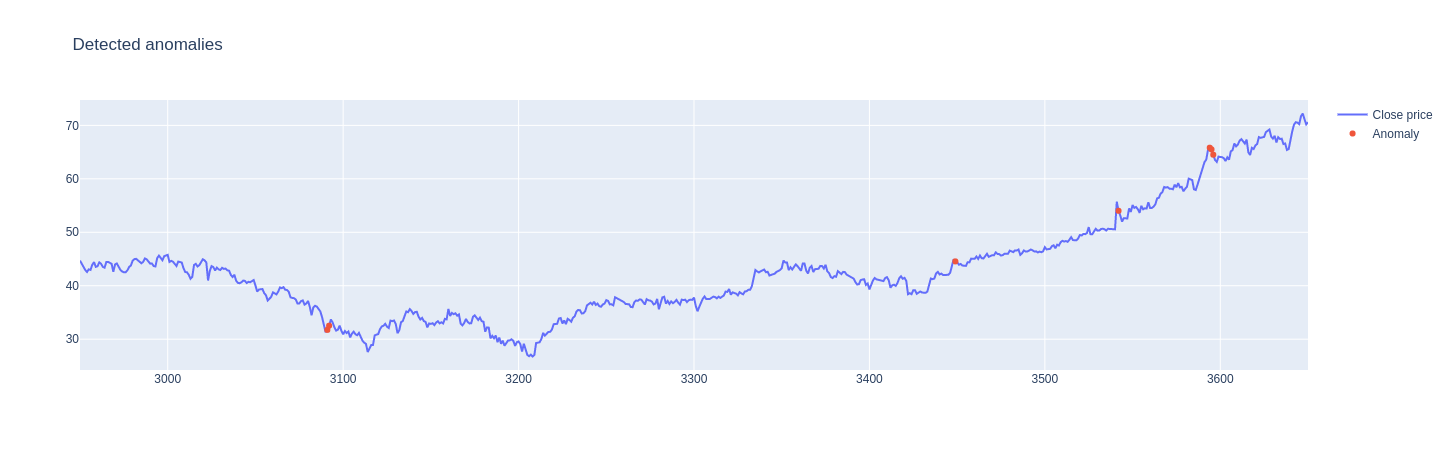

22/22 [==============================] - 0s 5ms/step - loss: 0.0705
0.07048970460891724


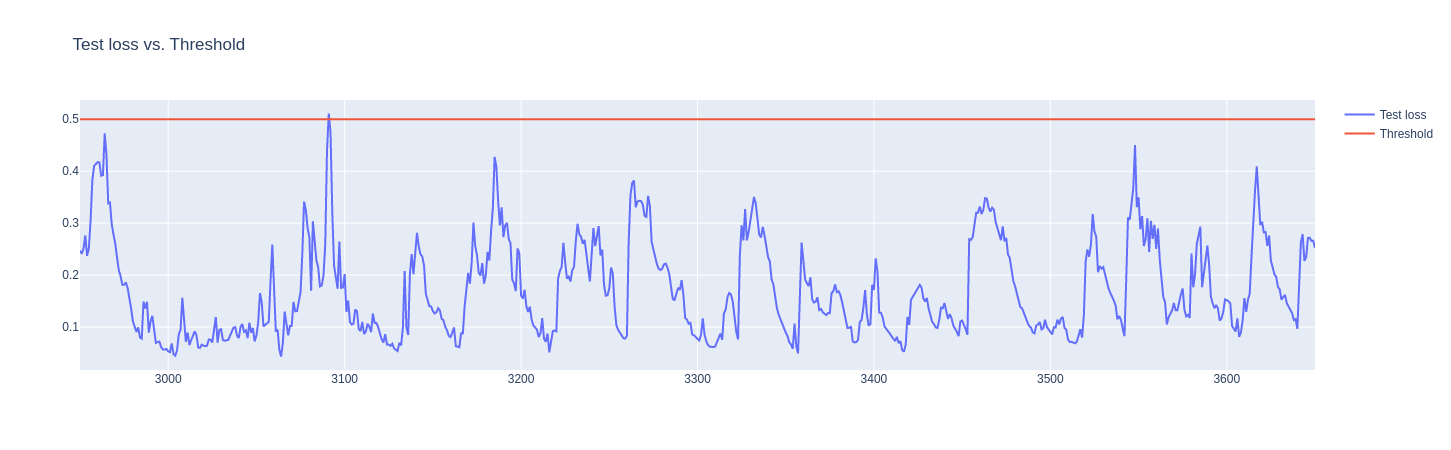

(1, 5)


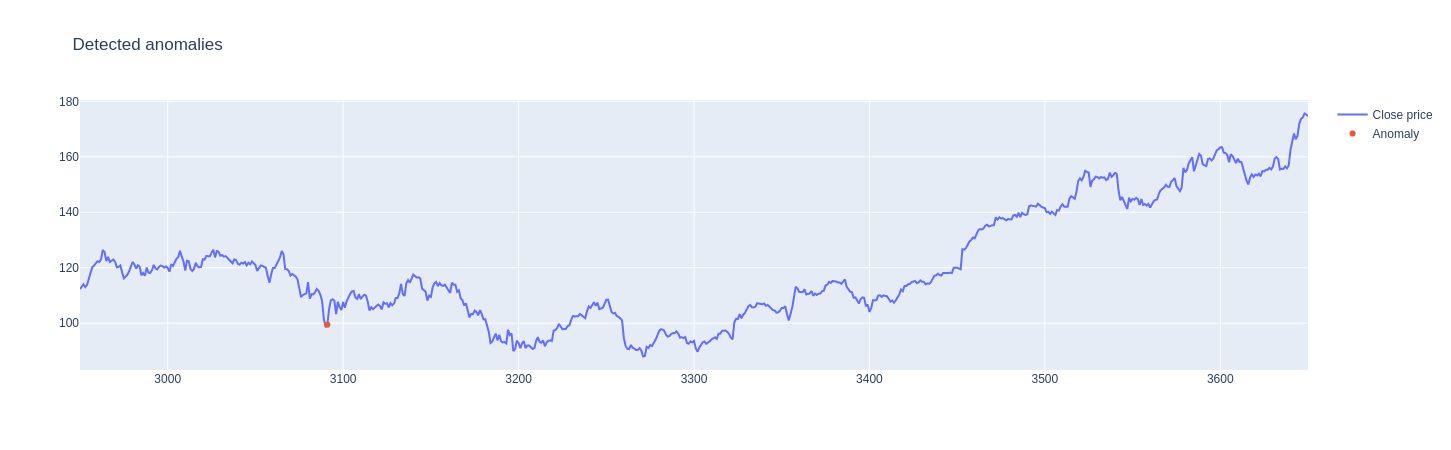

22/22 [==============================] - 0s 5ms/step - loss: 0.0847
0.0846569687128067


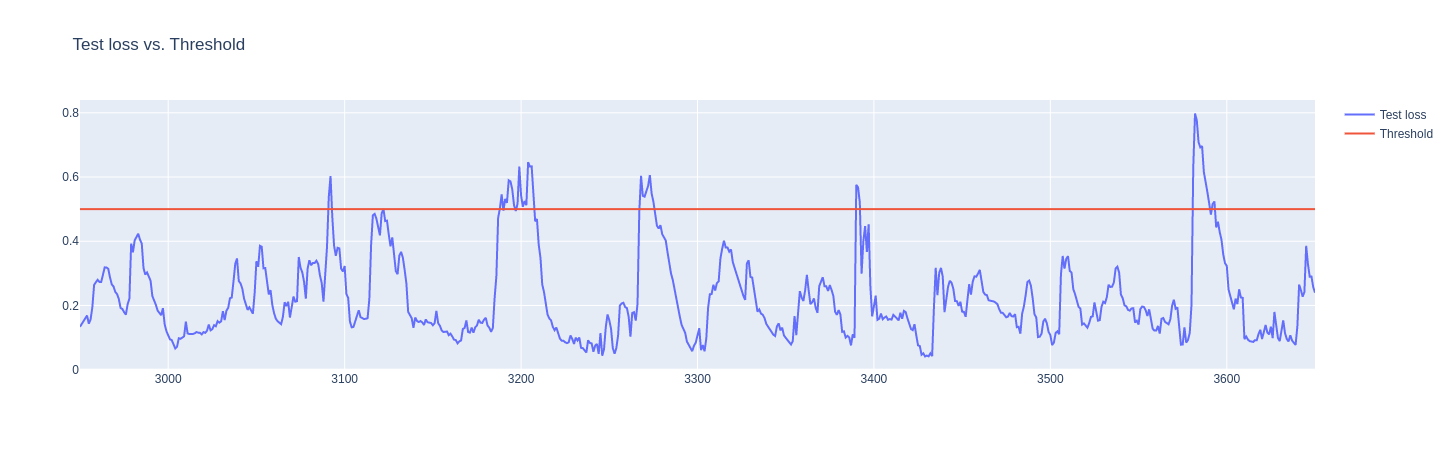

(44, 5)


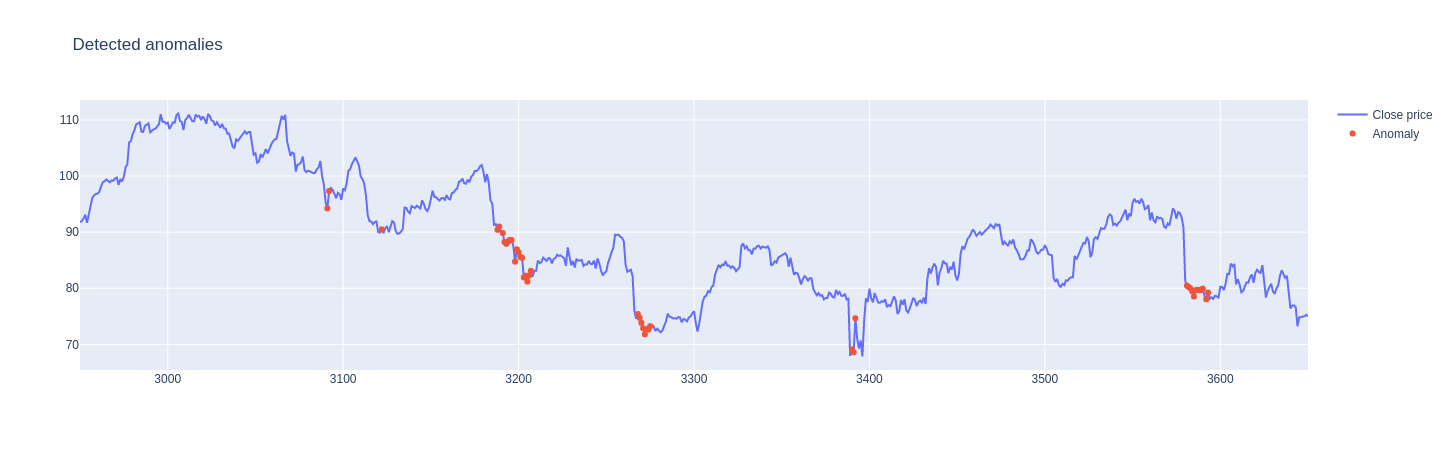

22/22 [==============================] - 0s 5ms/step - loss: 0.0953
0.09526997059583664


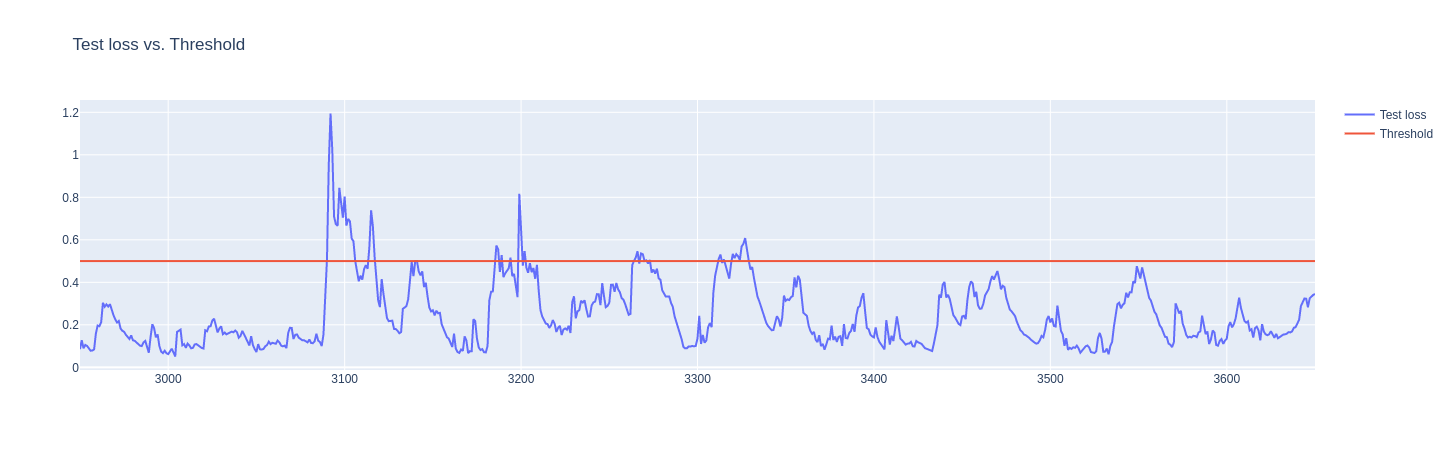

(48, 5)


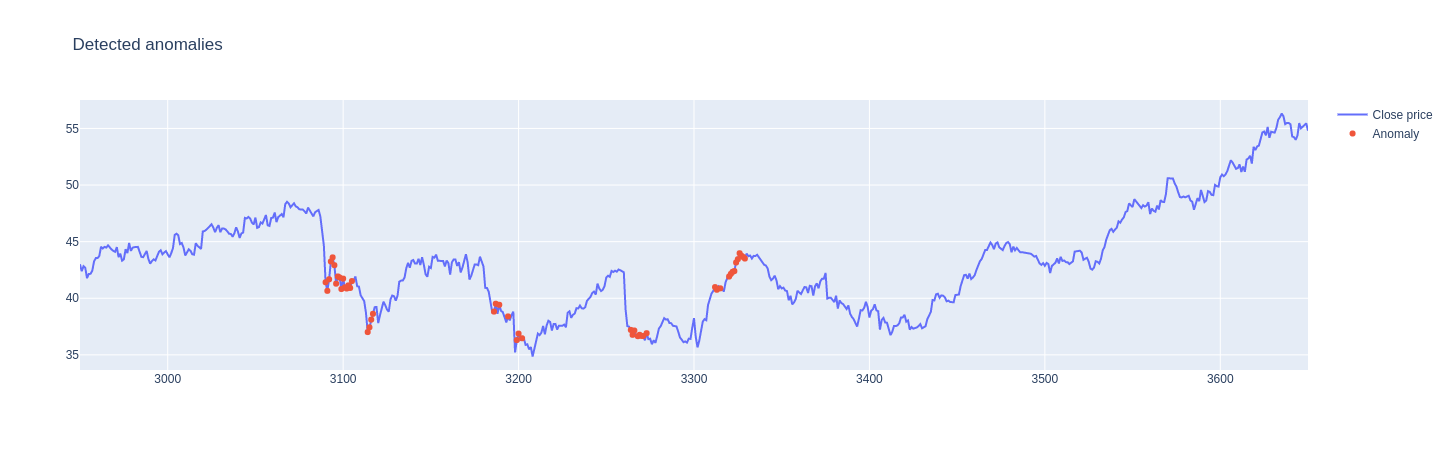

22/22 [==============================] - 0s 5ms/step - loss: 0.0981
0.09809930622577667


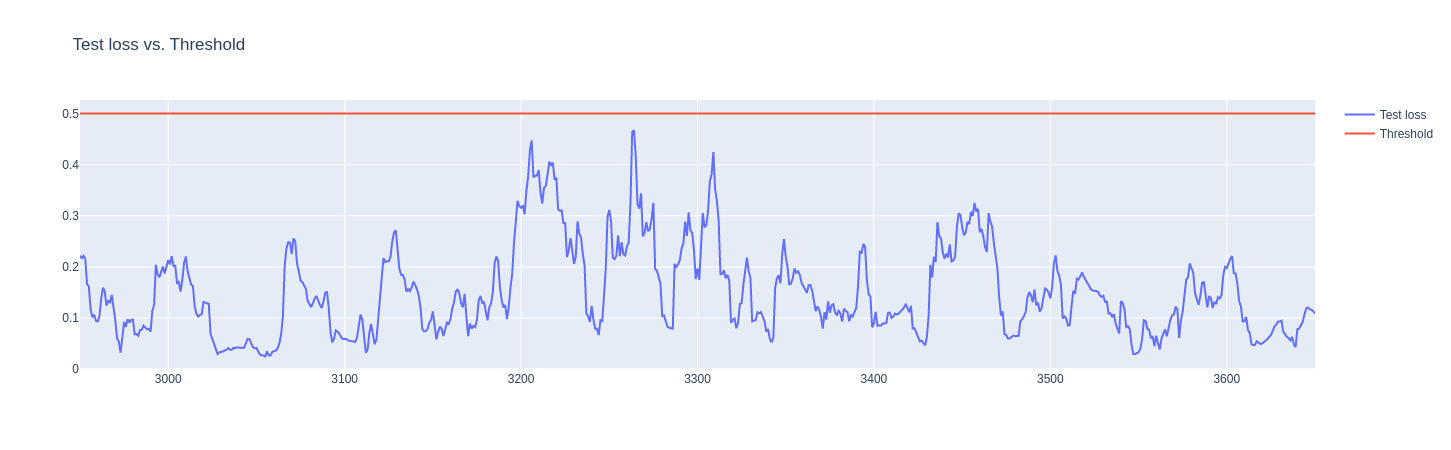

(0, 5)


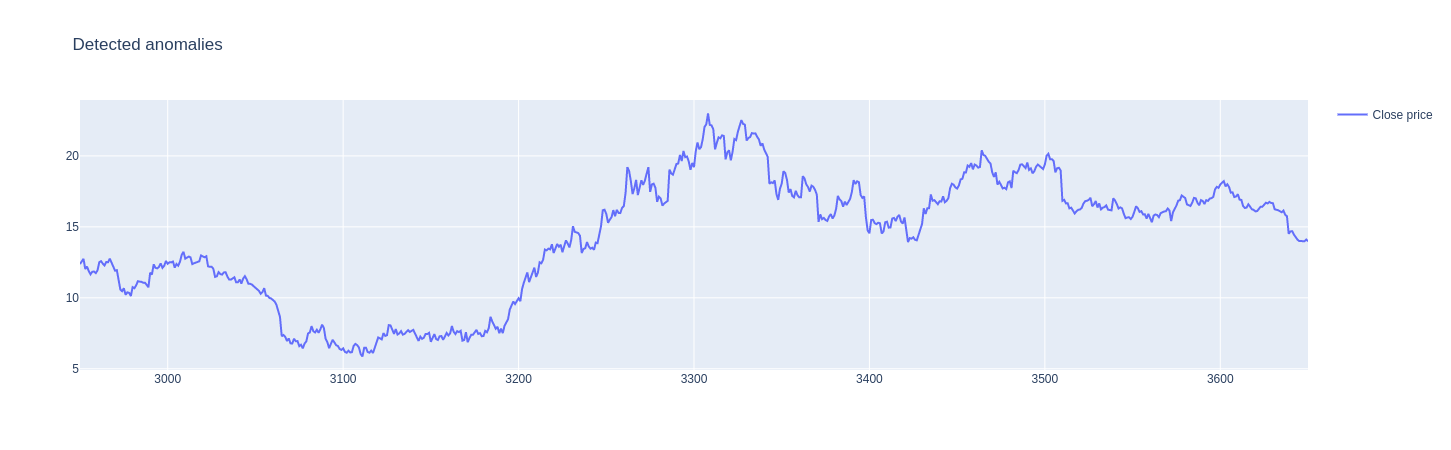

22/22 [==============================] - 0s 5ms/step - loss: 1.2015
1.2015143632888794


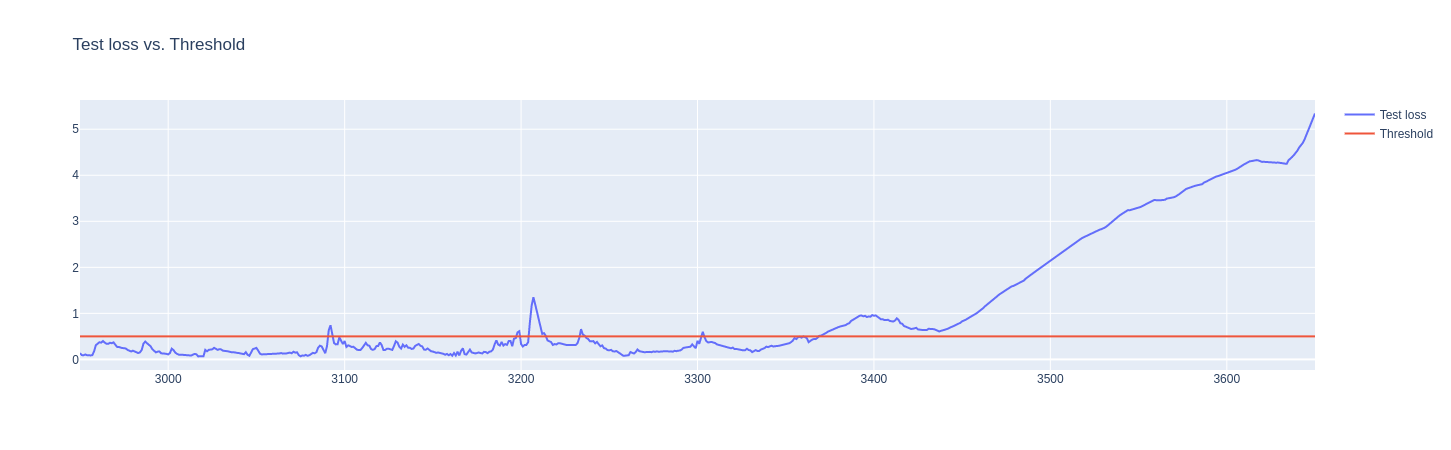

(301, 5)


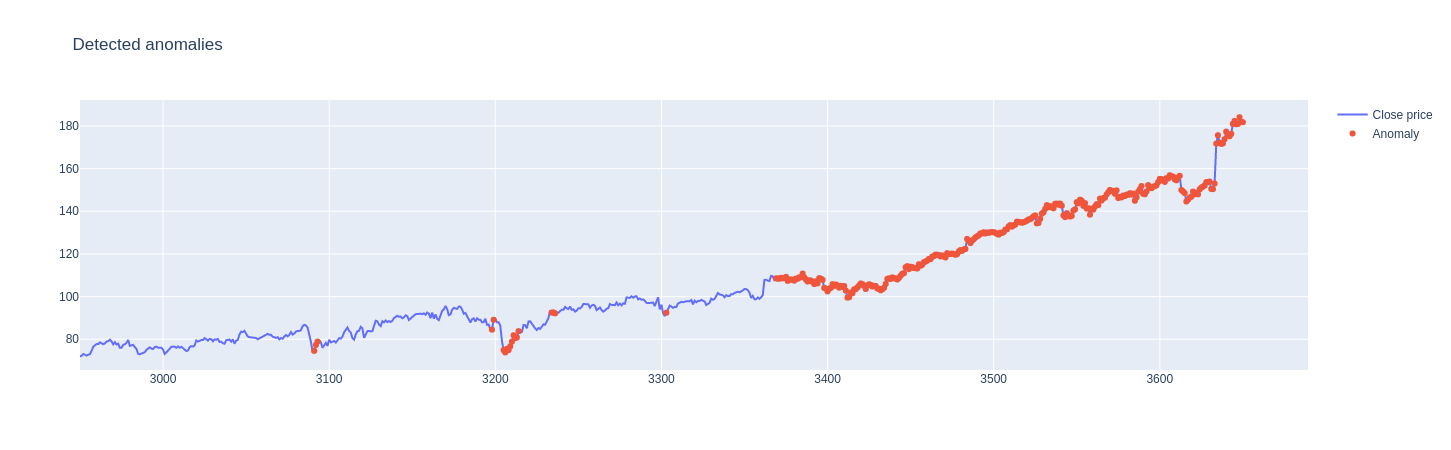

22/22 [==============================] - 0s 4ms/step - loss: 0.5082
0.5082303285598755


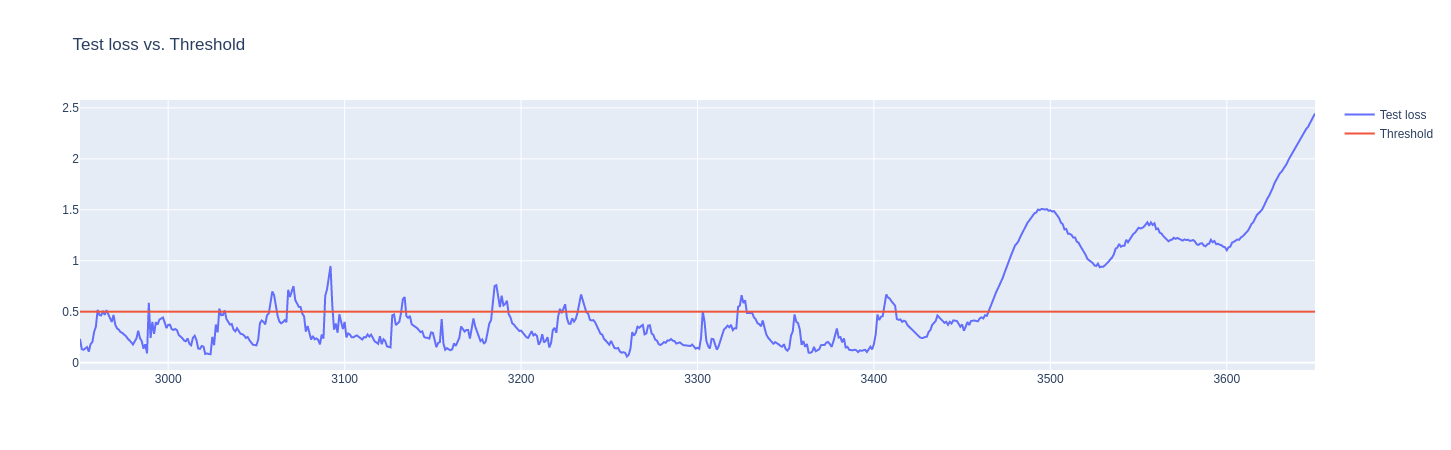

(239, 5)


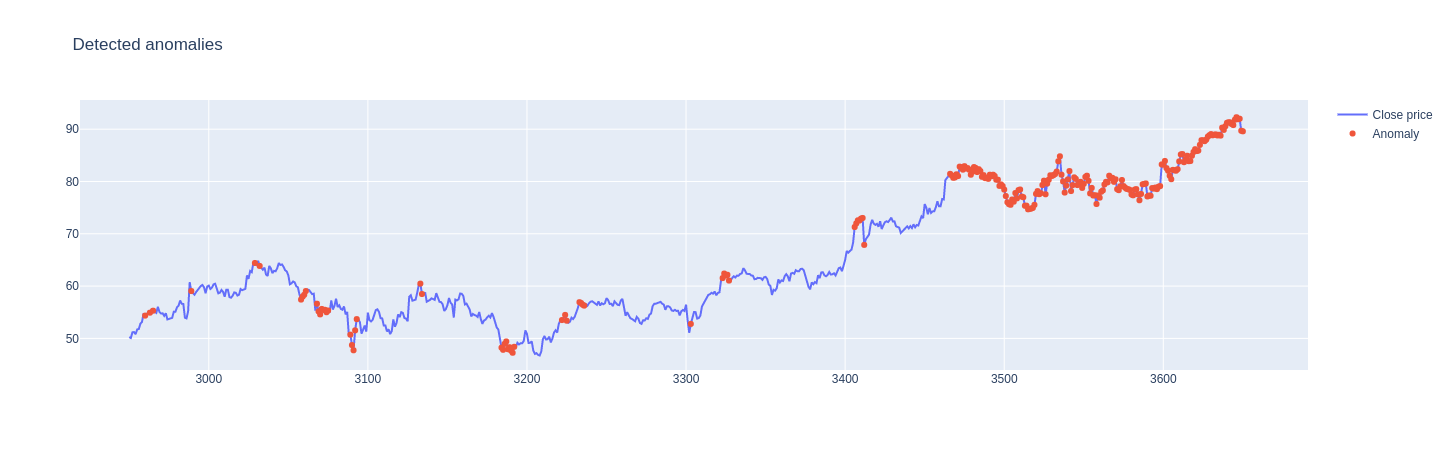

22/22 [==============================] - 0s 5ms/step - loss: 0.0654
0.06544089317321777


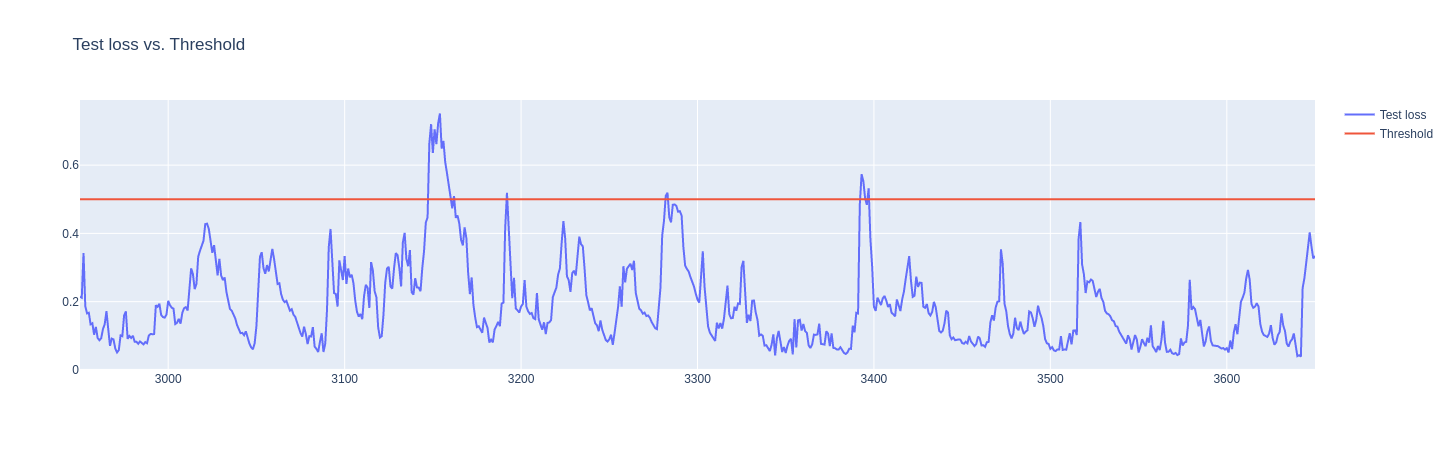

(20, 5)


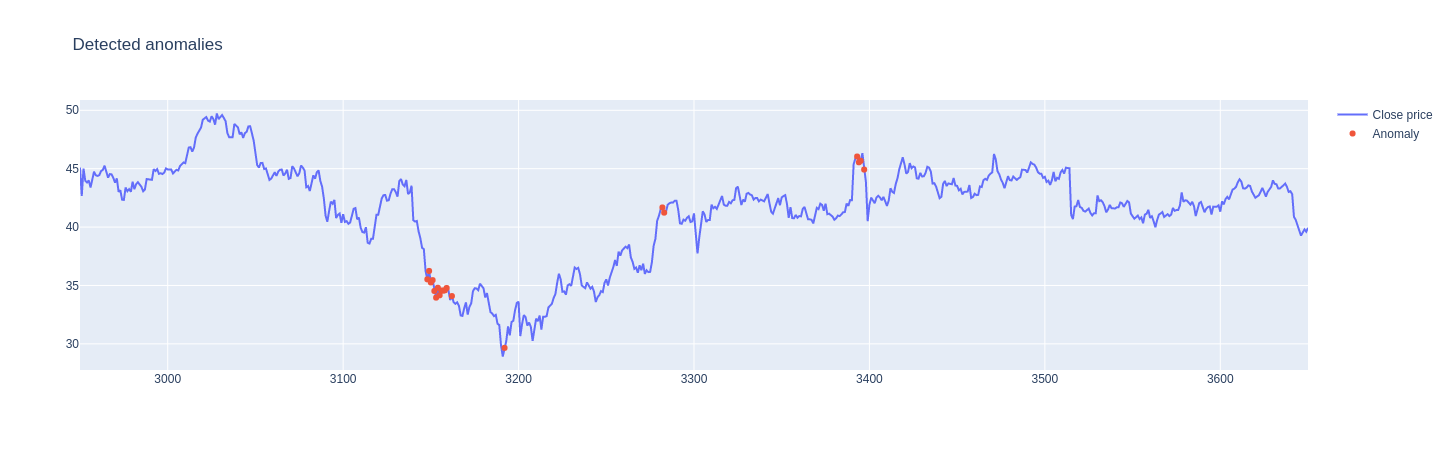

22/22 [==============================] - 0s 5ms/step - loss: 0.0649
0.06487638503313065


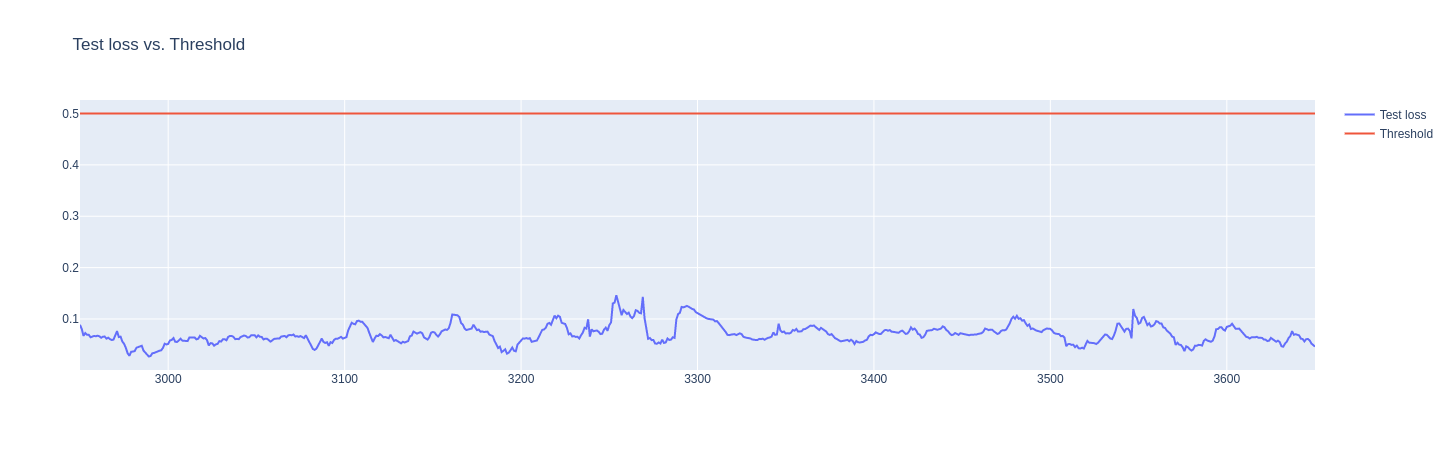

(0, 5)


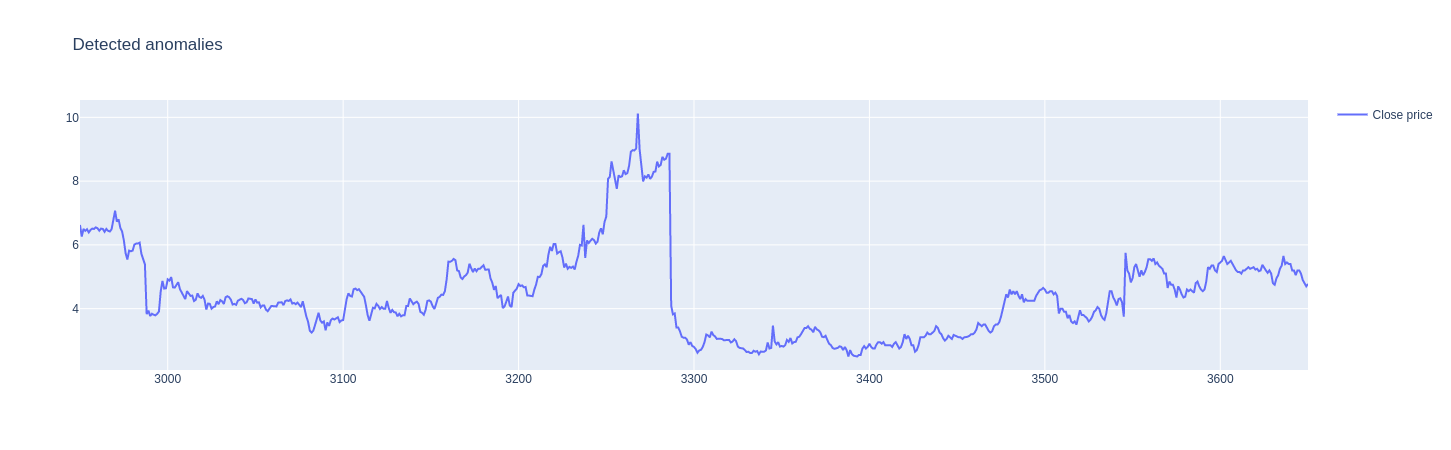

22/22 [==============================] - 0s 5ms/step - loss: 0.2918
0.29183411598205566


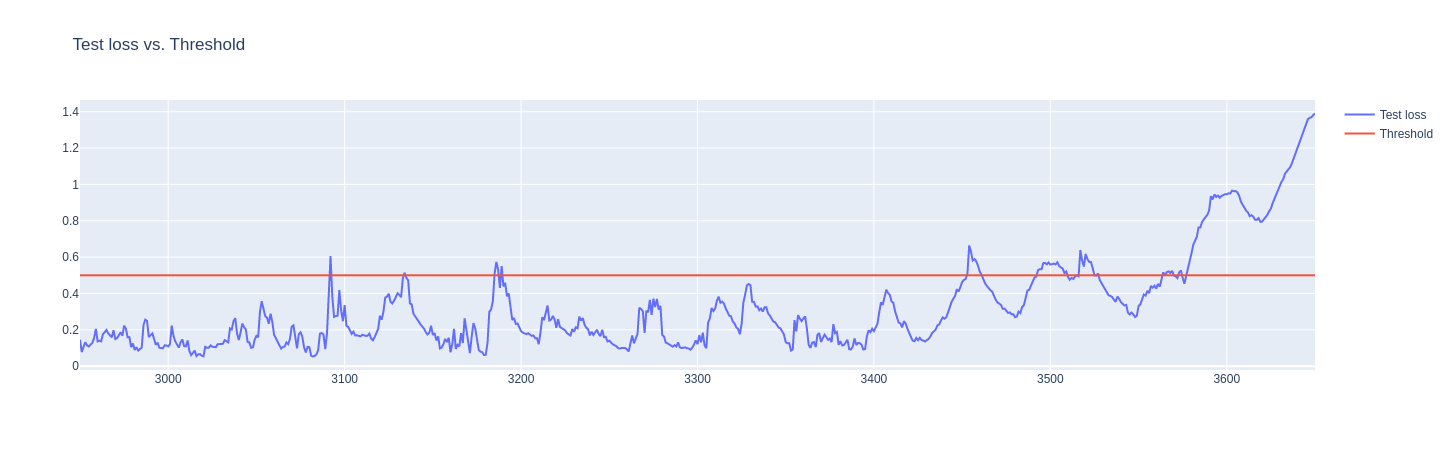

(122, 5)


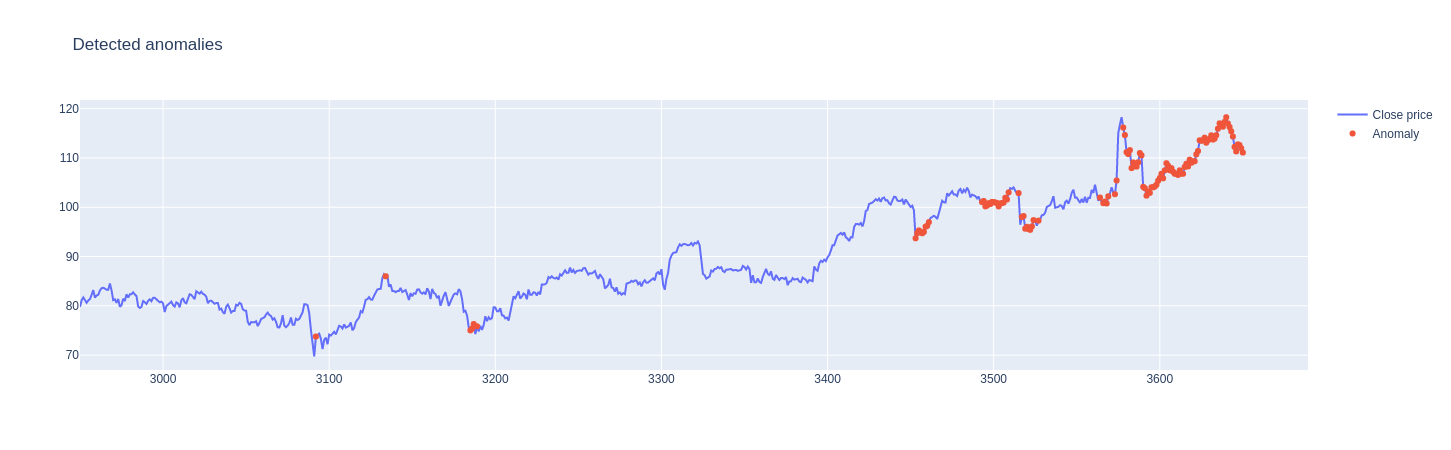

22/22 [==============================] - 0s 5ms/step - loss: 0.4043
0.4042518734931946


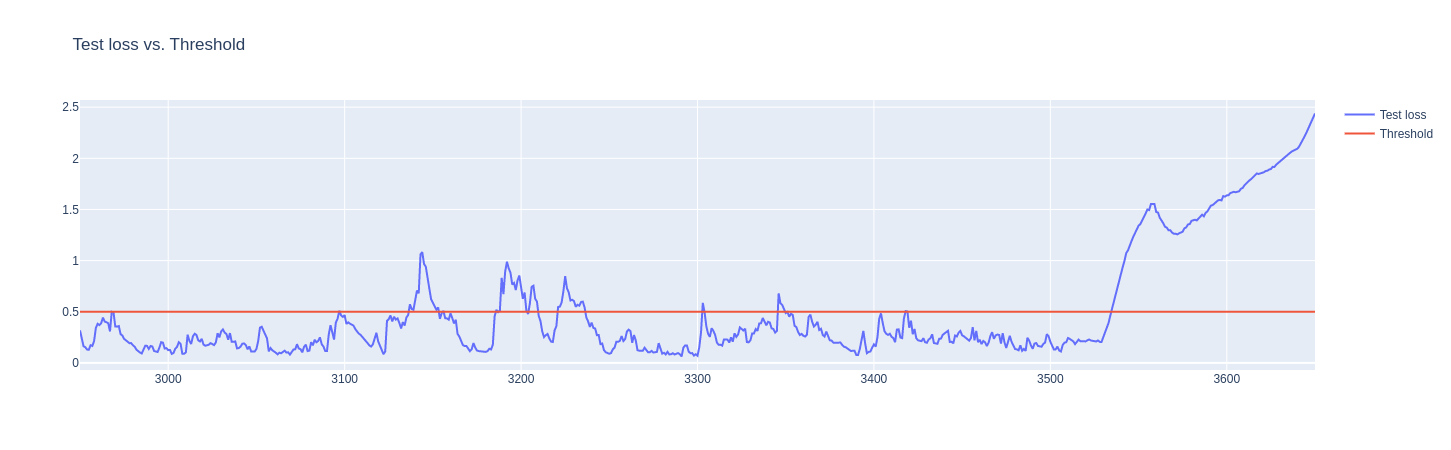

(180, 5)


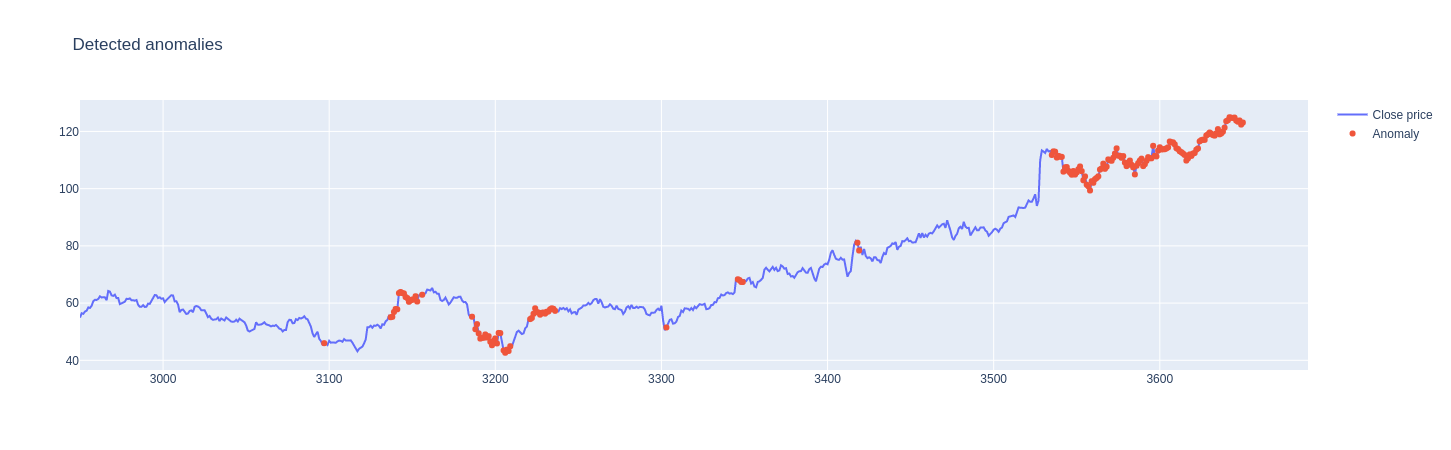

22/22 [==============================] - 0s 5ms/step - loss: 0.0627
0.06269142776727676


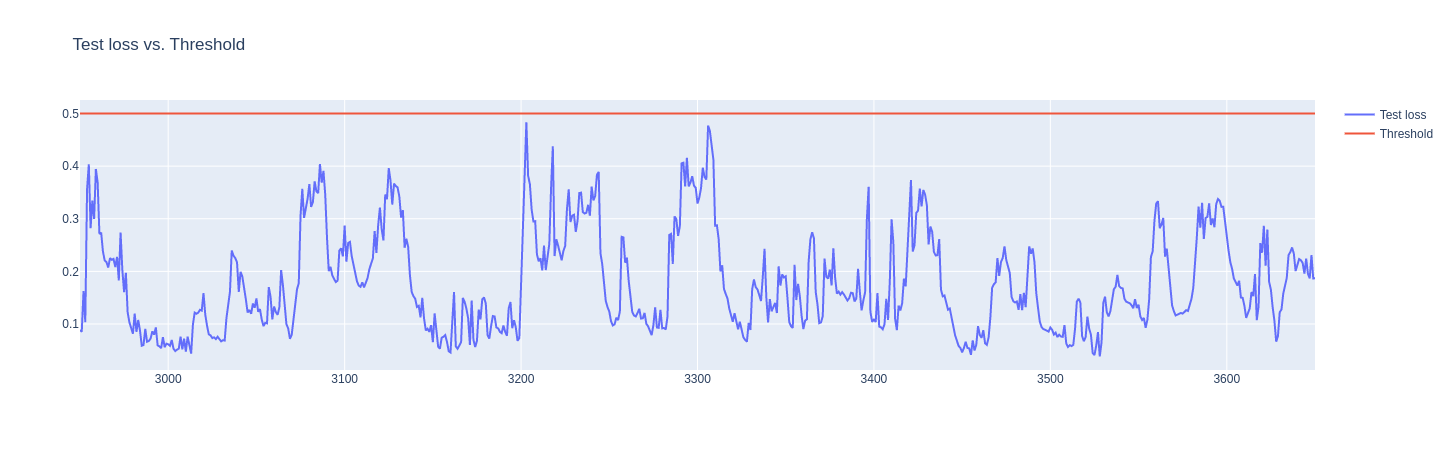

(0, 5)


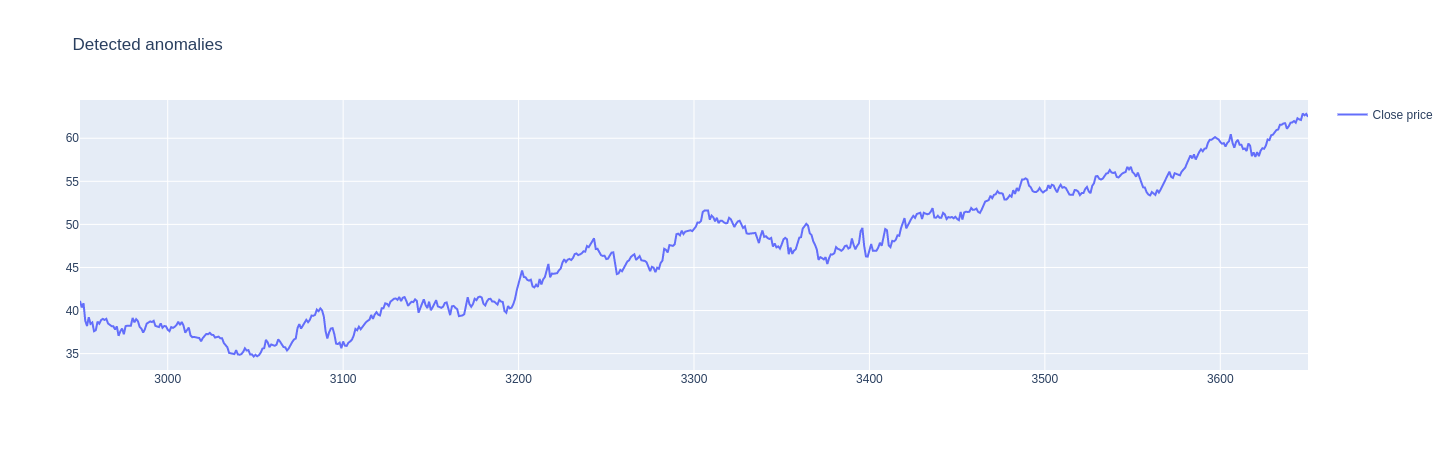

22/22 [==============================] - 0s 5ms/step - loss: 0.0568
0.05682690814137459


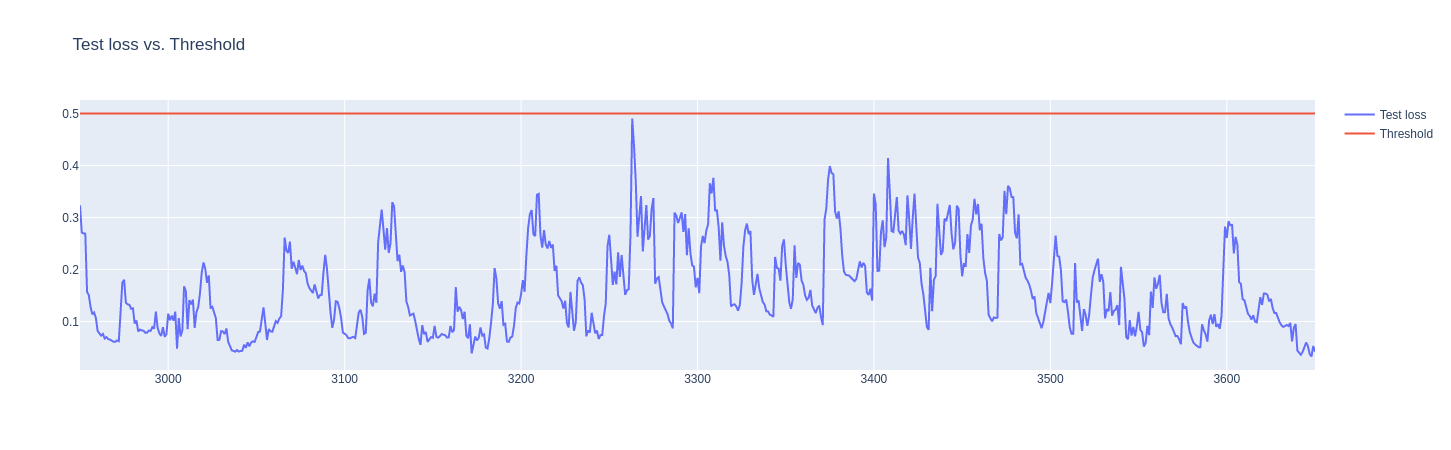

(0, 5)


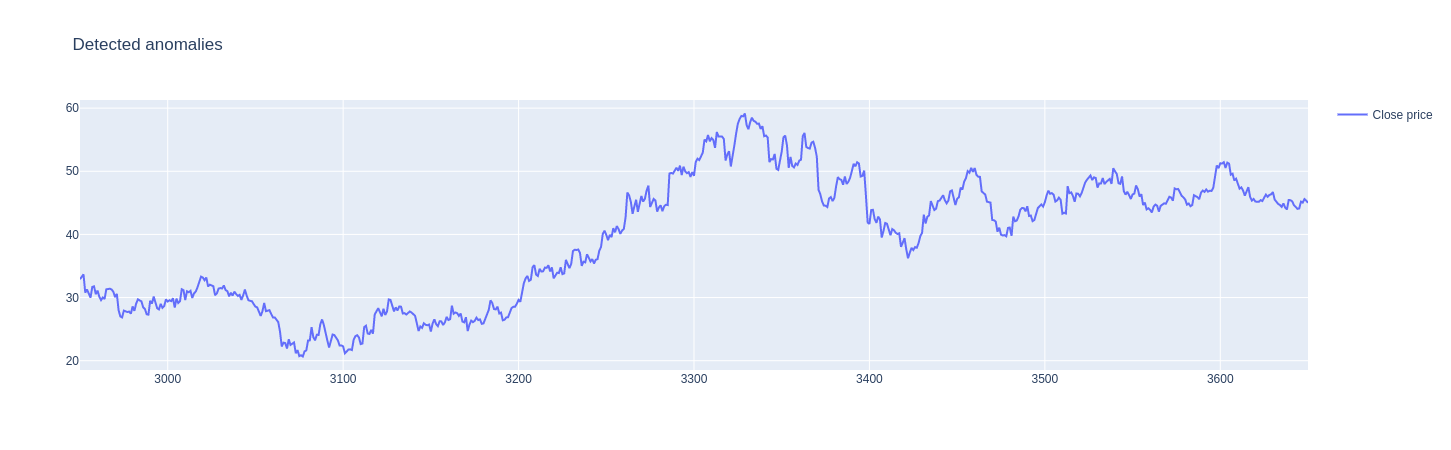

22/22 [==============================] - 0s 5ms/step - loss: 0.2655
0.2654769718647003


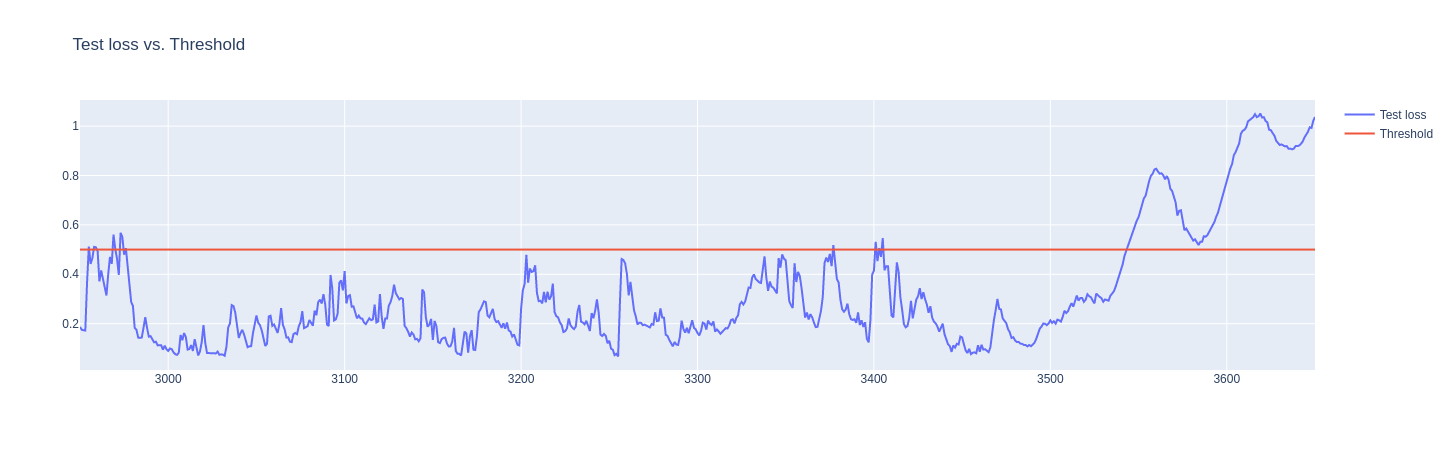

(119, 5)


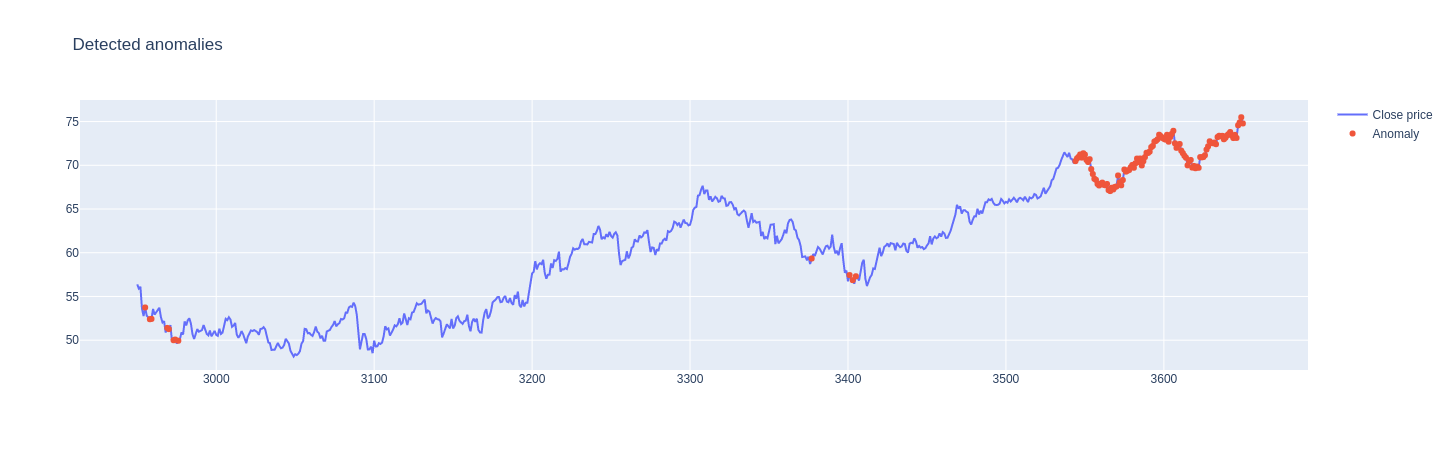

22/22 [==============================] - 0s 5ms/step - loss: 0.0527
0.05270221456885338


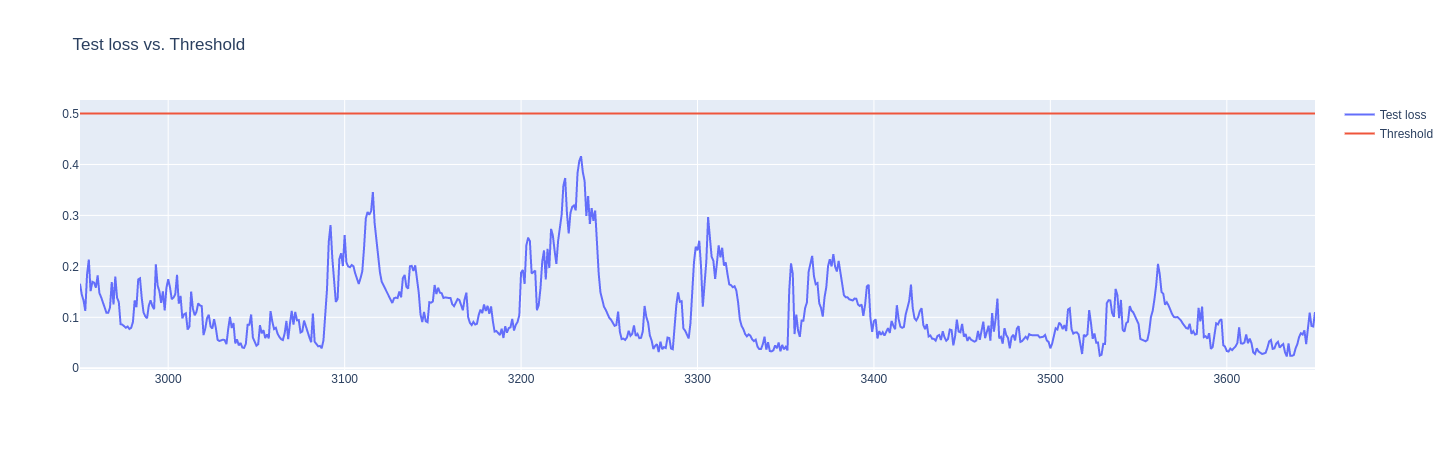

(0, 5)


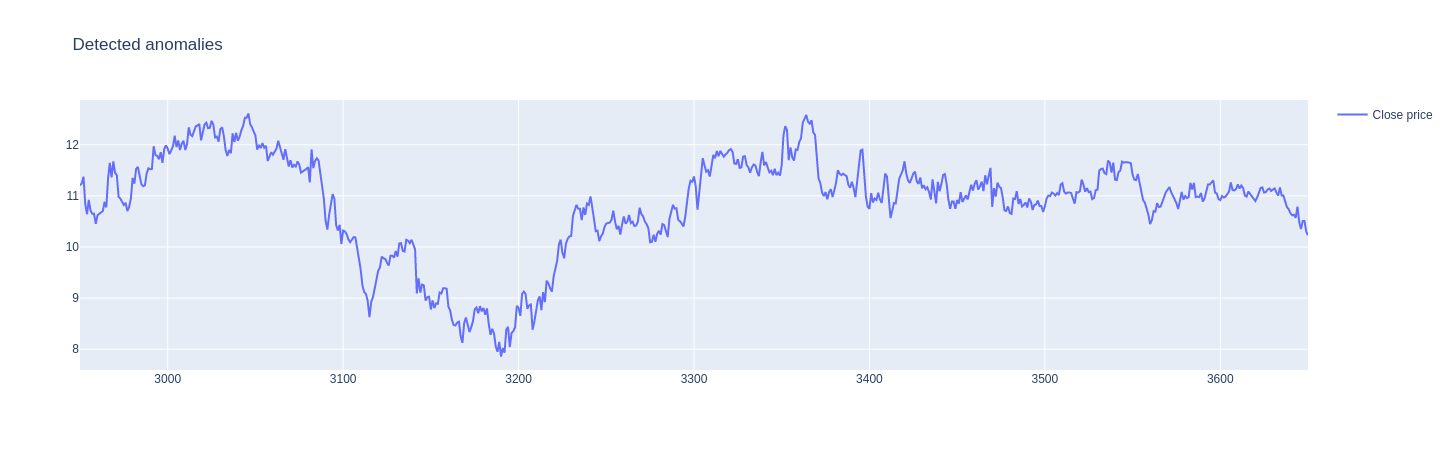

22/22 [==============================] - 0s 6ms/step - loss: 0.6858
0.6857671141624451


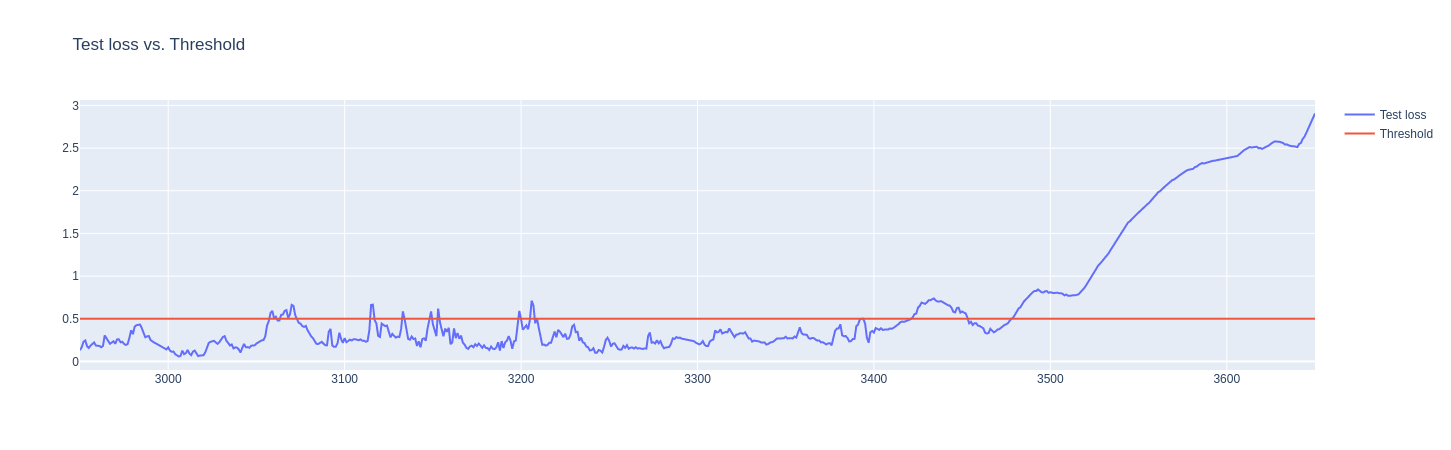

(227, 5)


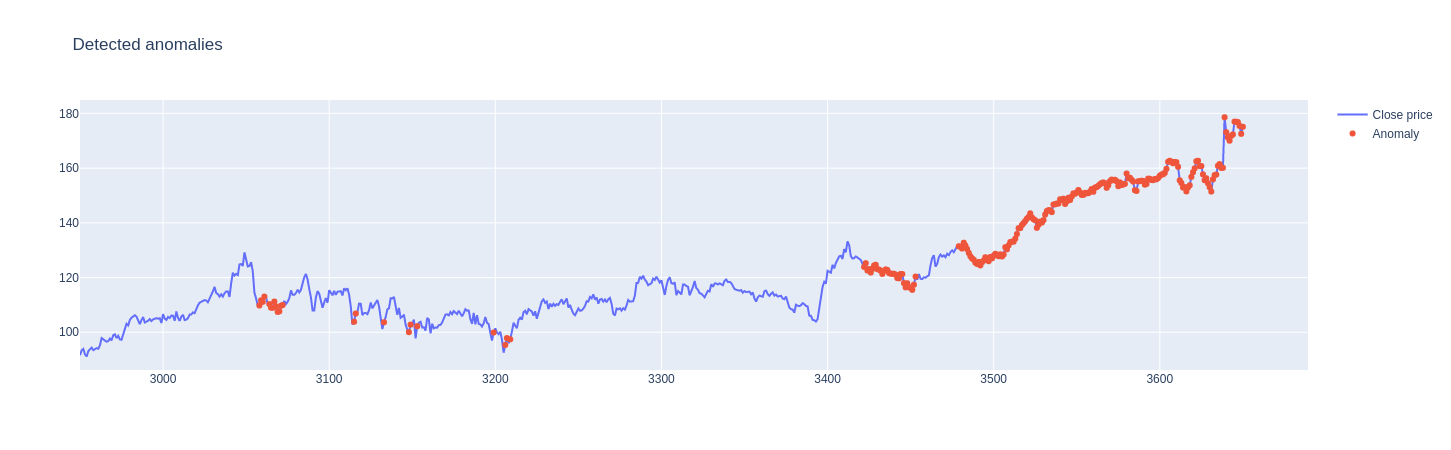

22/22 [==============================] - 0s 5ms/step - loss: 0.0676
0.0675731748342514


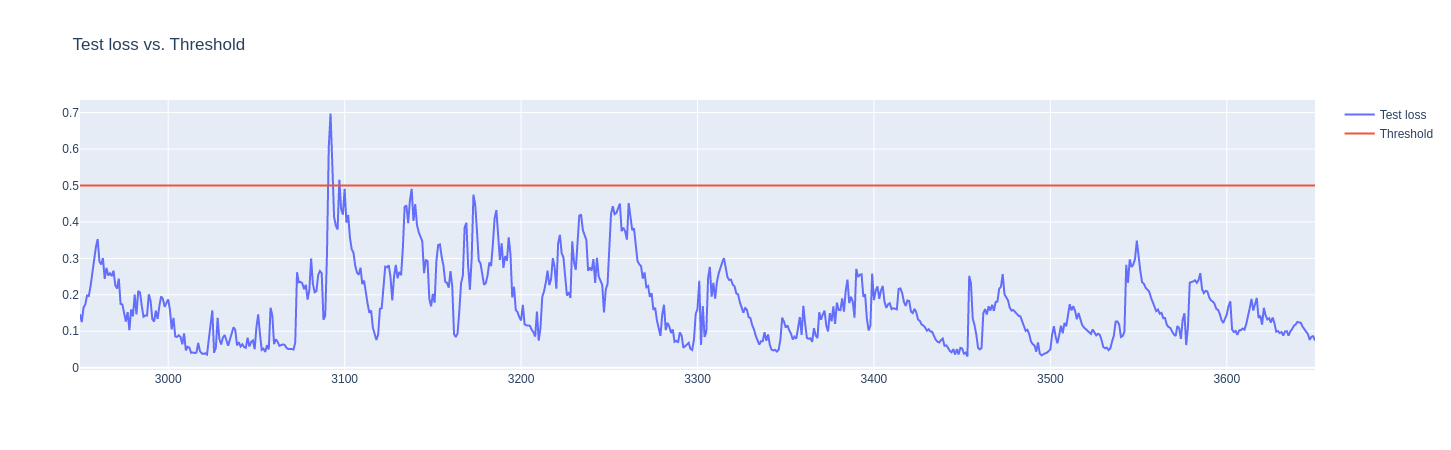

(4, 5)


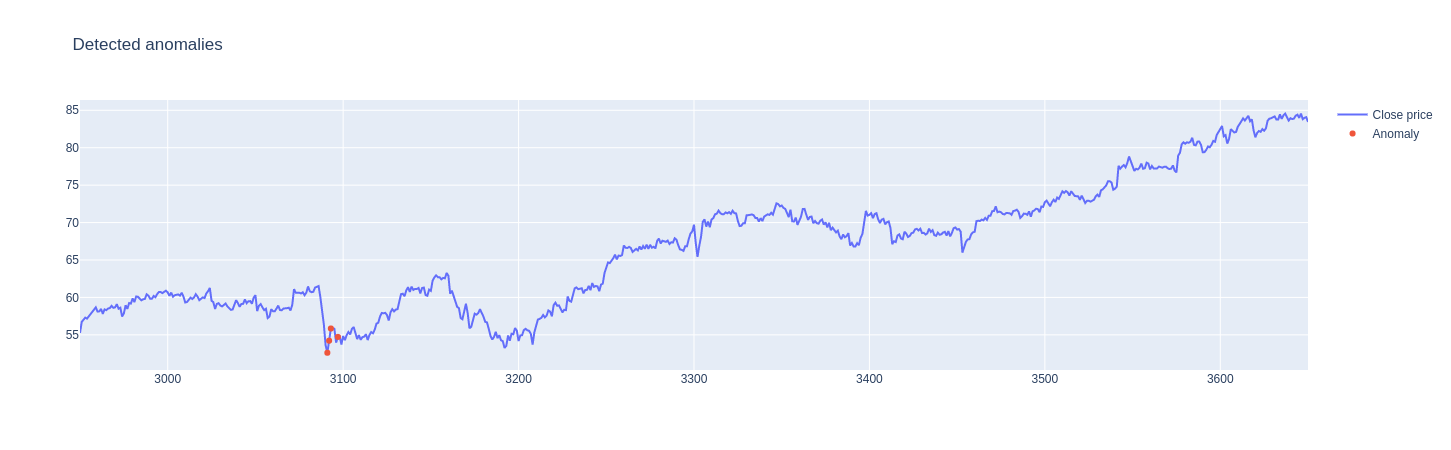

22/22 [==============================] - 0s 5ms/step - loss: 0.0910
0.09096447378396988


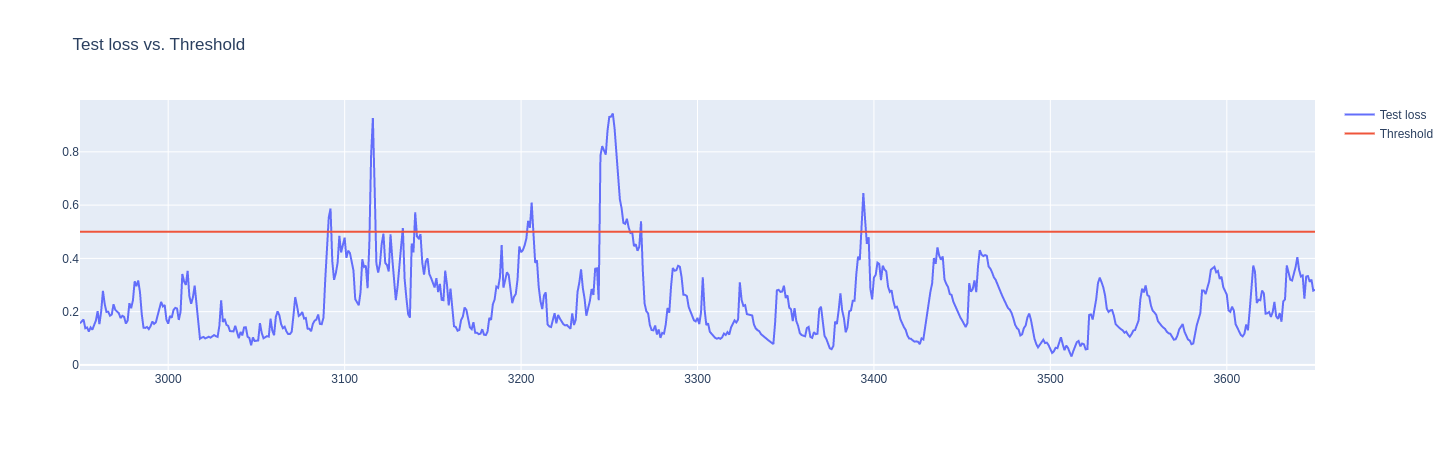

(31, 5)


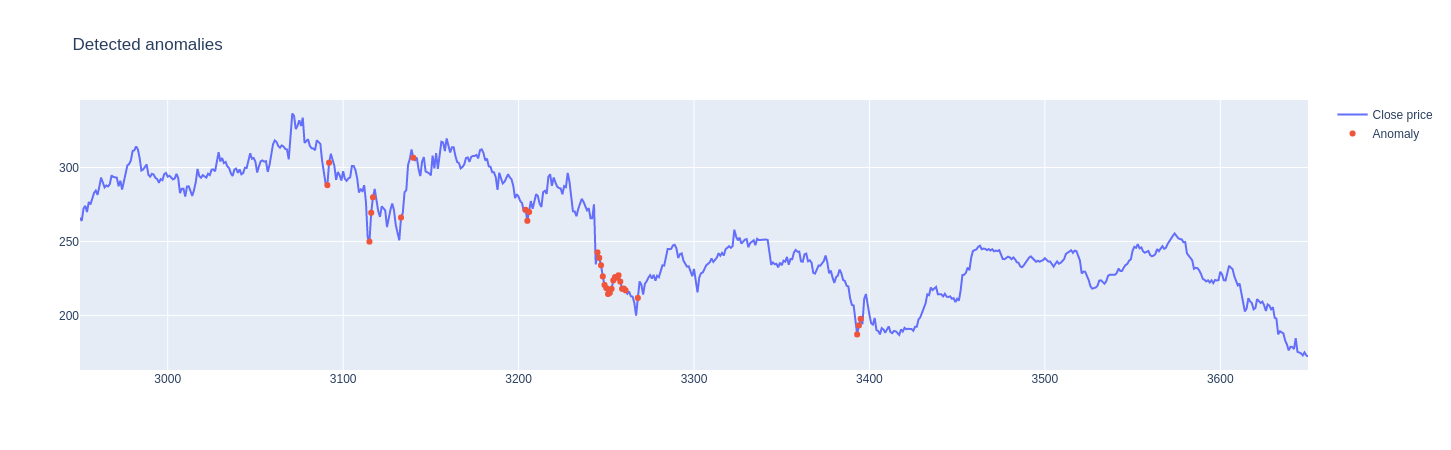

22/22 [==============================] - 0s 5ms/step - loss: 0.0941
0.09412074089050293


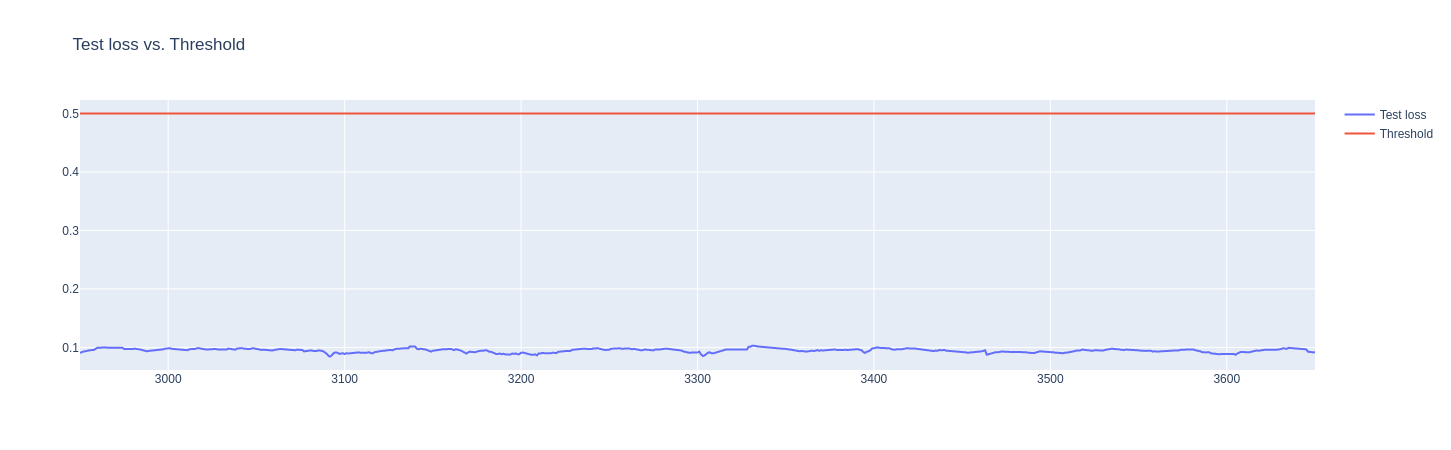

(0, 5)


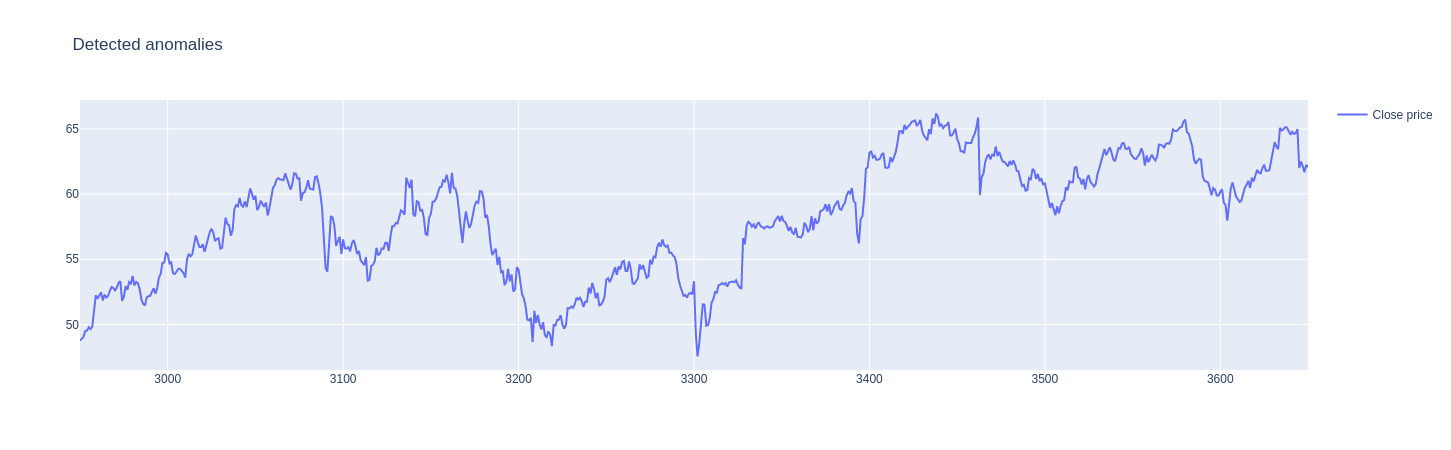

22/22 [==============================] - 0s 5ms/step - loss: 0.0461
0.046054352074861526


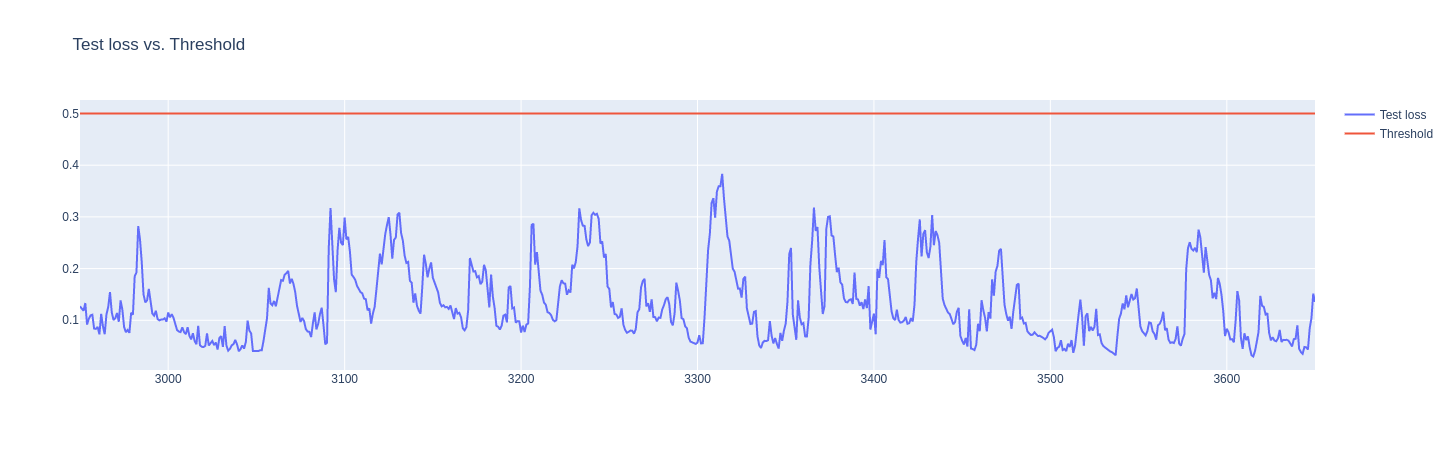

(0, 5)


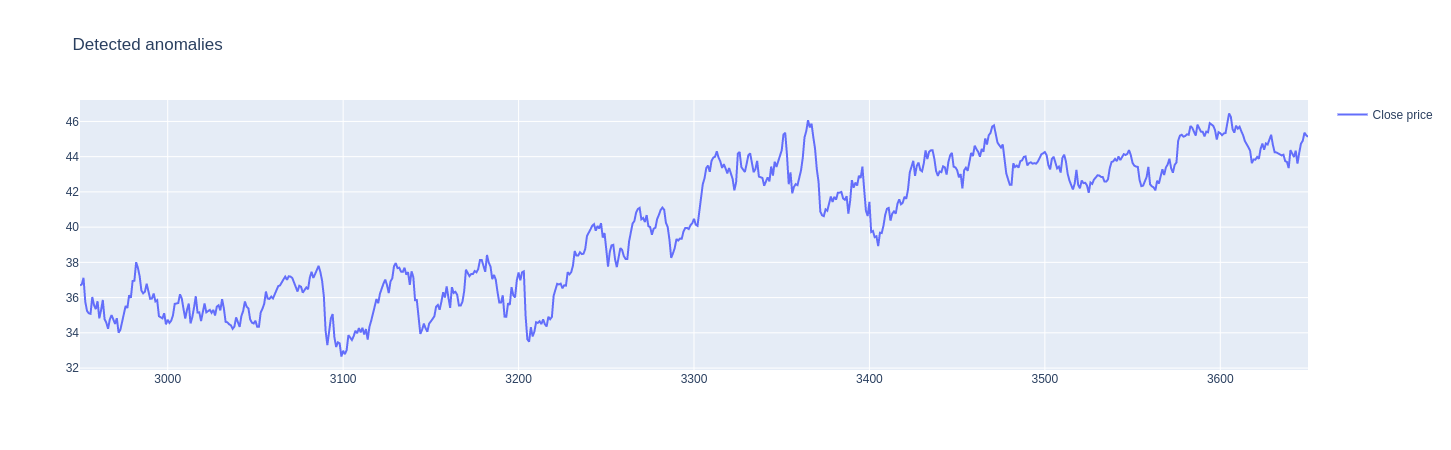

22/22 [==============================] - 0s 6ms/step - loss: 0.0776
0.07757297158241272


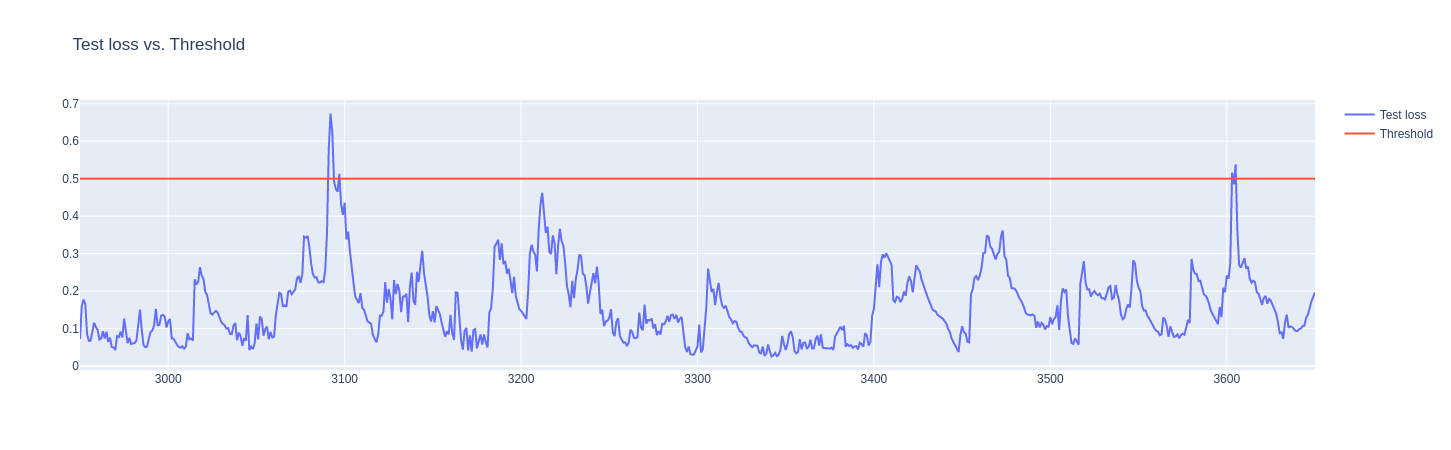

(6, 5)


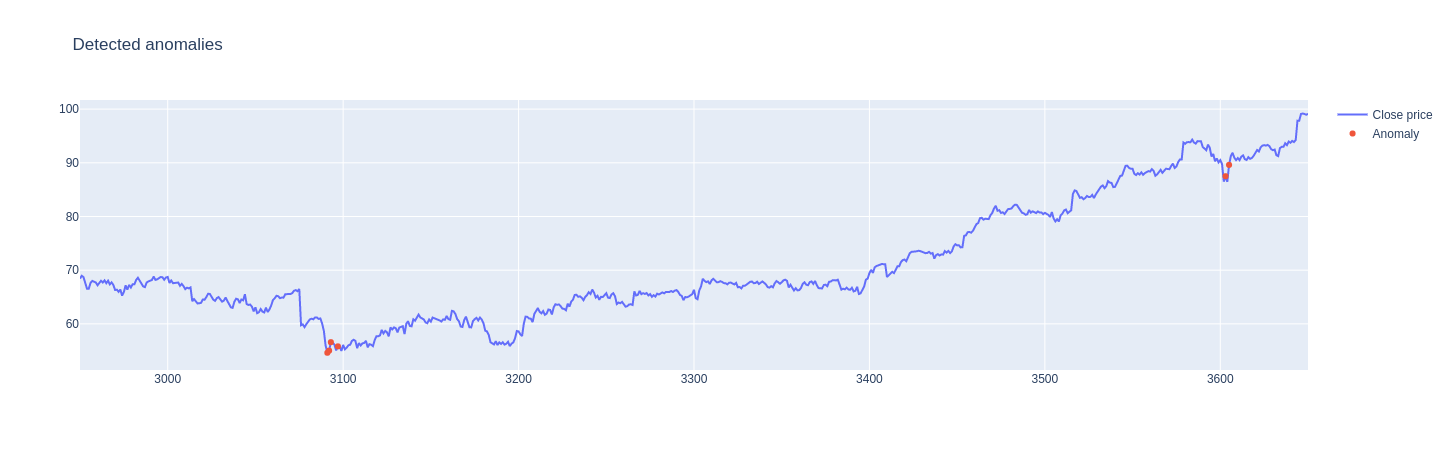

22/22 [==============================] - 0s 5ms/step - loss: 1.2149
1.2148855924606323


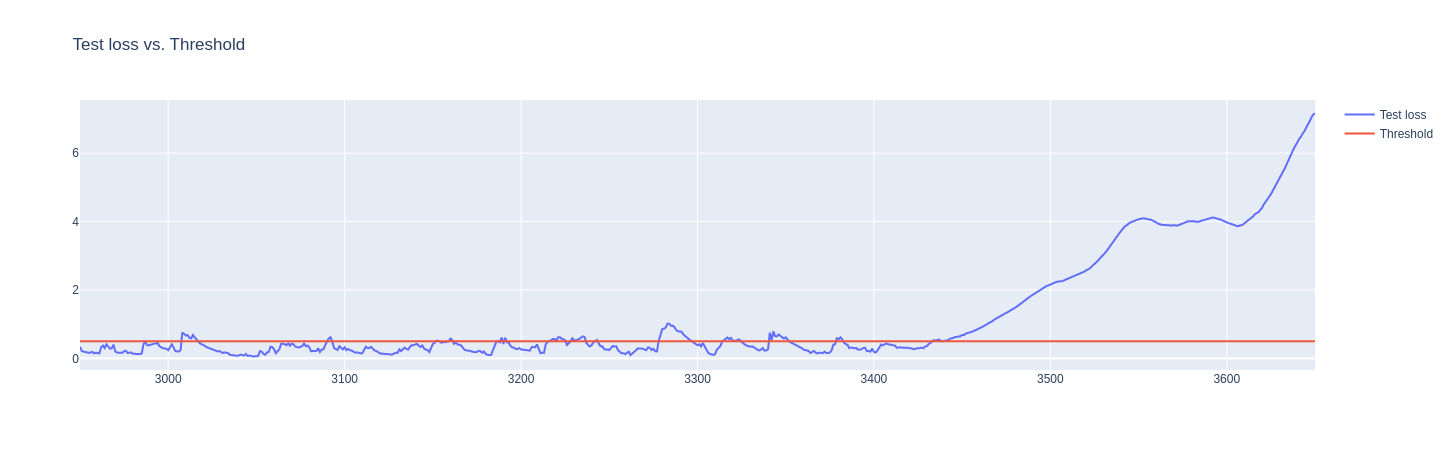

(300, 5)


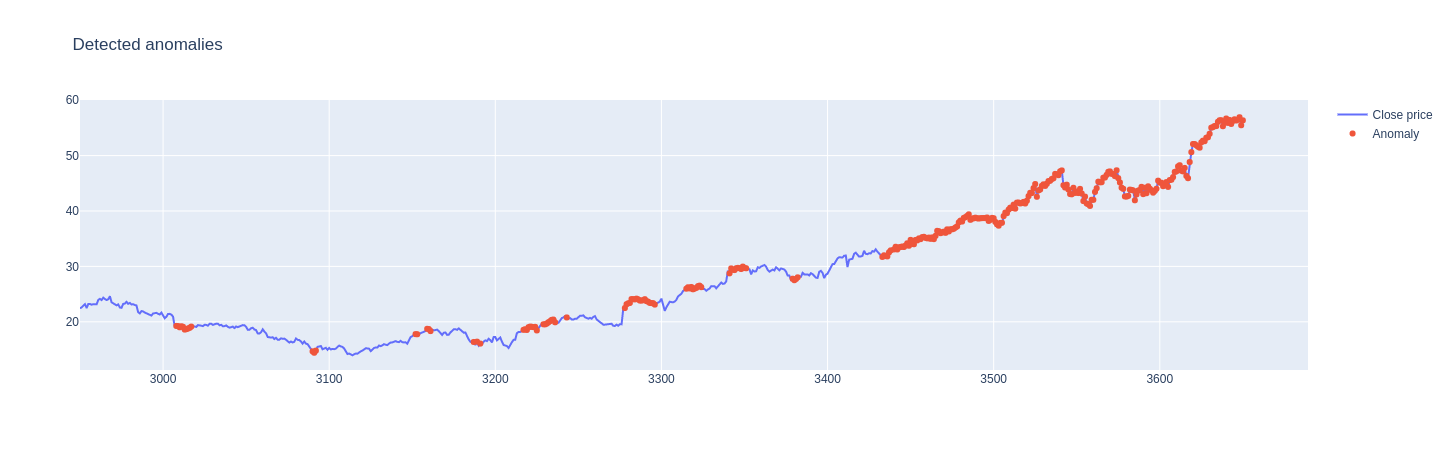

22/22 [==============================] - 0s 5ms/step - loss: 0.0725
0.07250125706195831


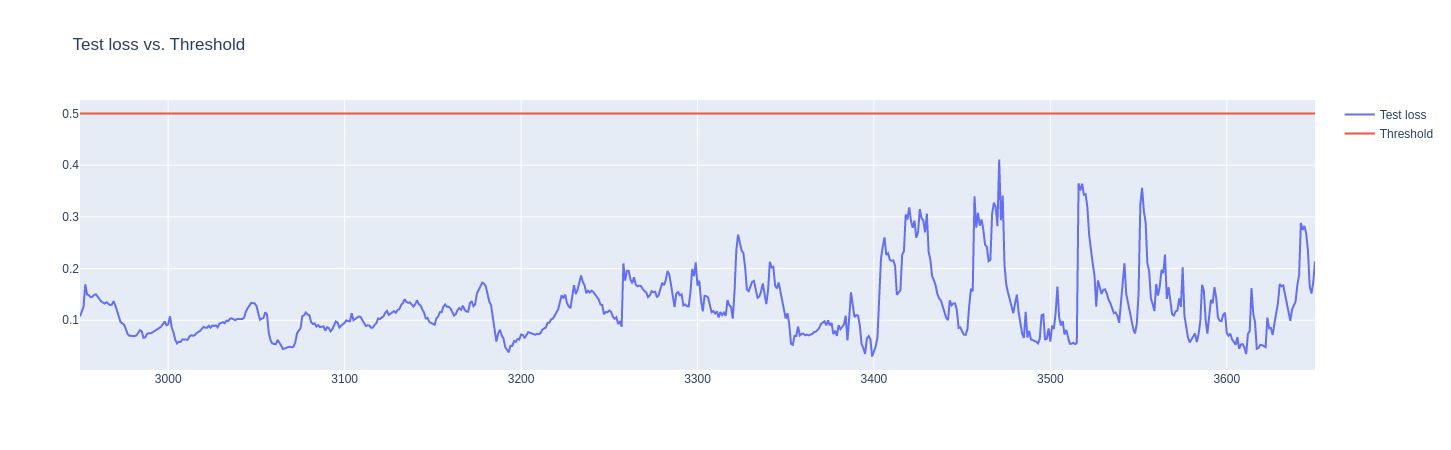

(0, 5)


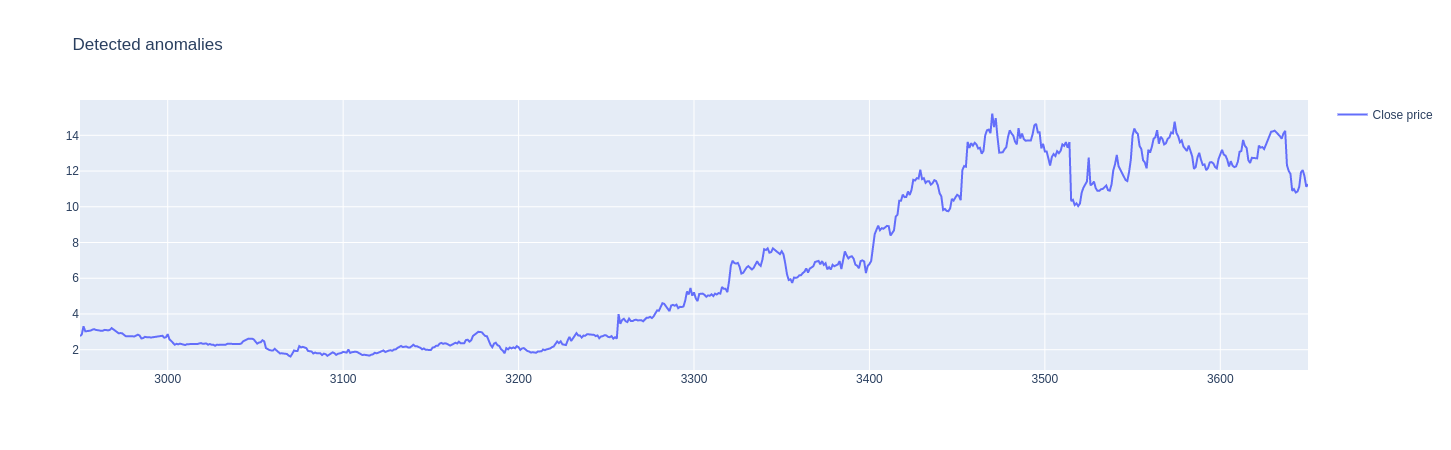

22/22 [==============================] - 0s 5ms/step - loss: 0.1511
0.151077538728714


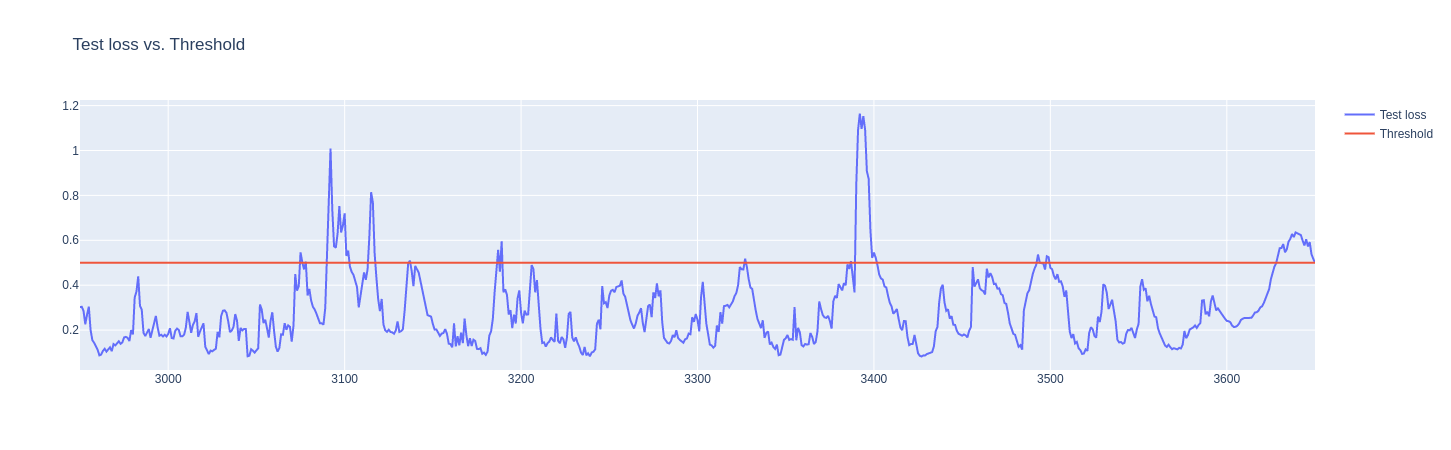

(62, 5)


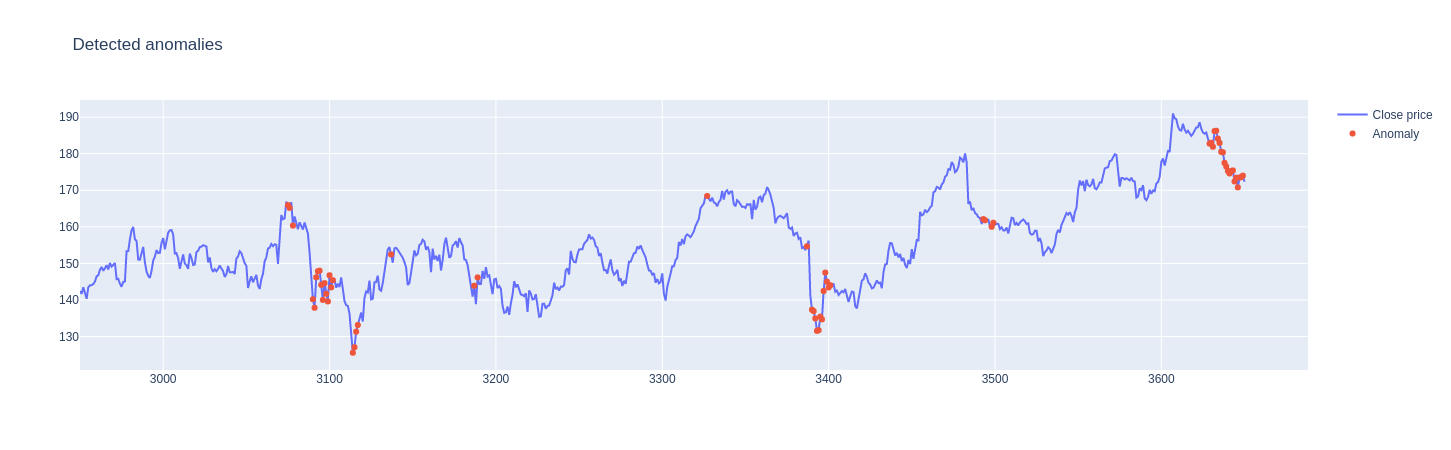

22/22 [==============================] - 0s 5ms/step - loss: 1.2095
1.2095495462417603


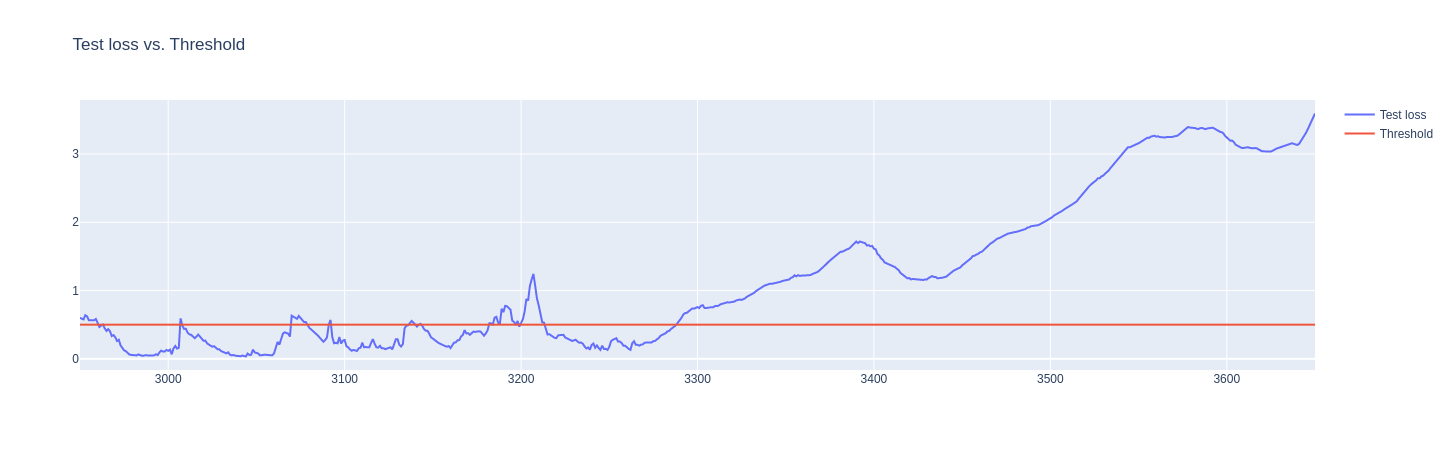

(420, 5)


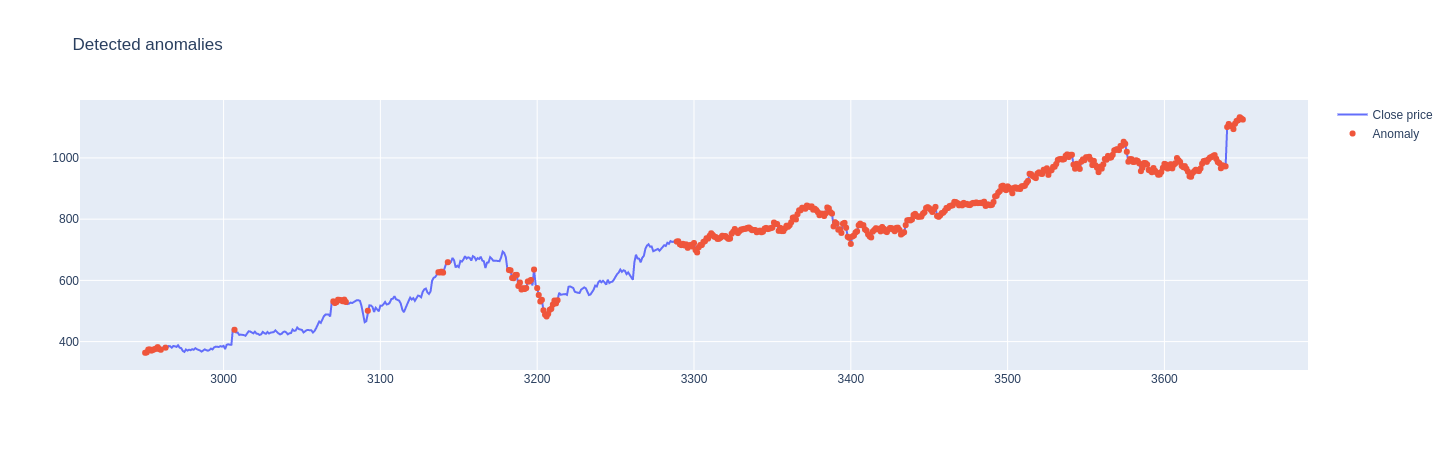

22/22 [==============================] - 0s 5ms/step - loss: 0.0548
0.054754097014665604


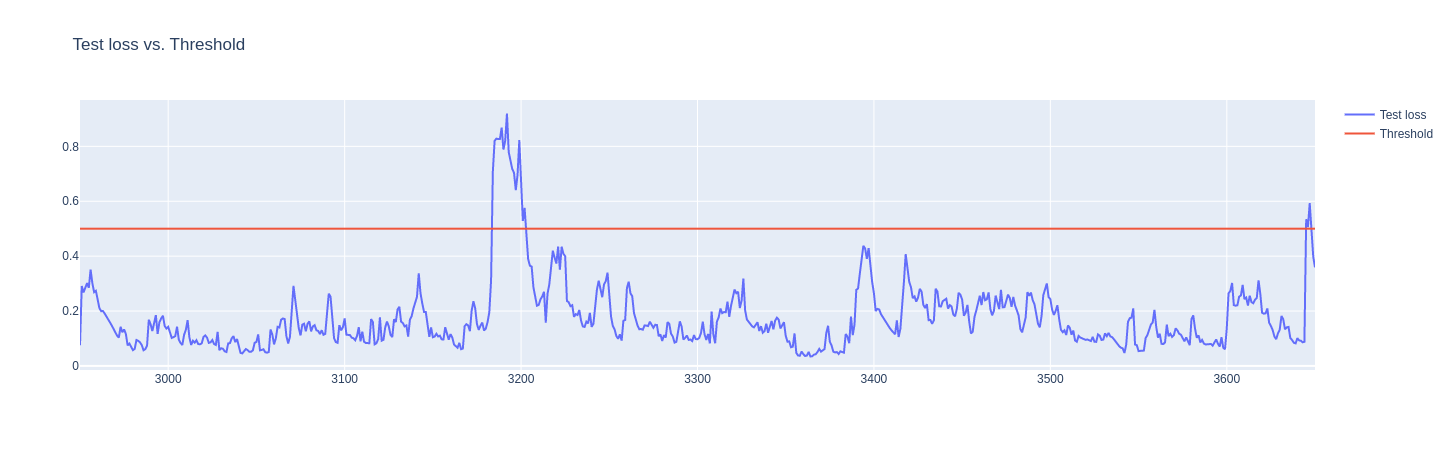

(22, 5)


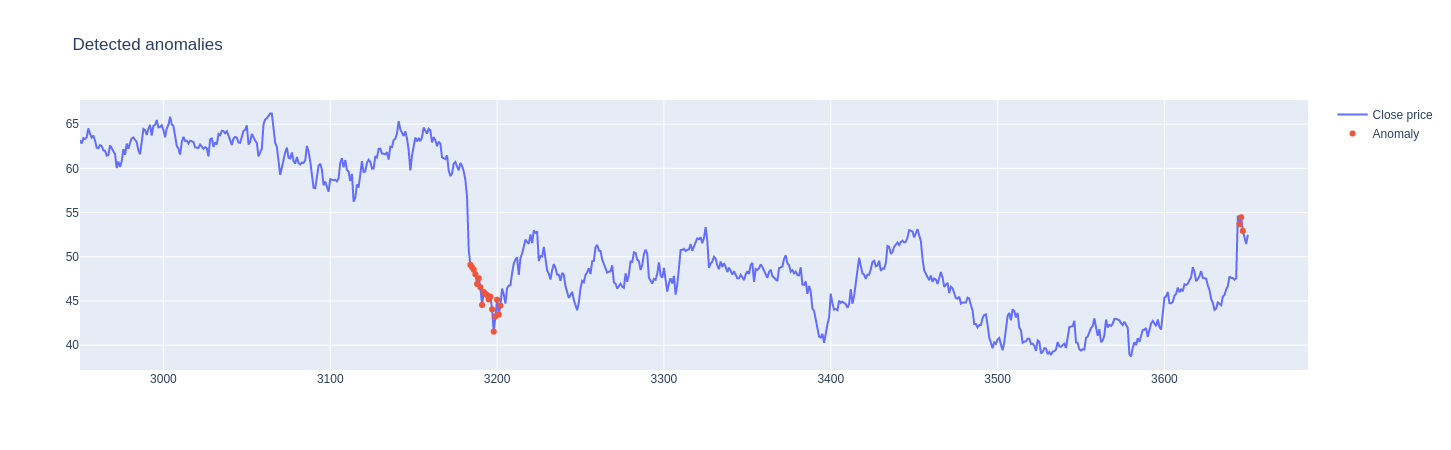

22/22 [==============================] - 0s 5ms/step - loss: 0.6840
0.6840041875839233


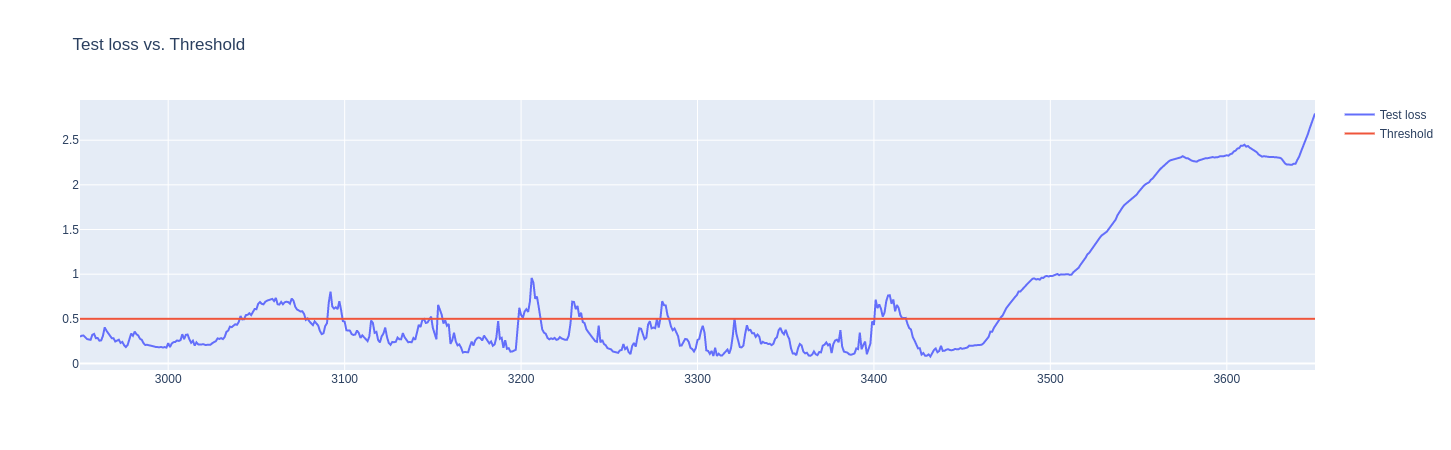

(269, 5)


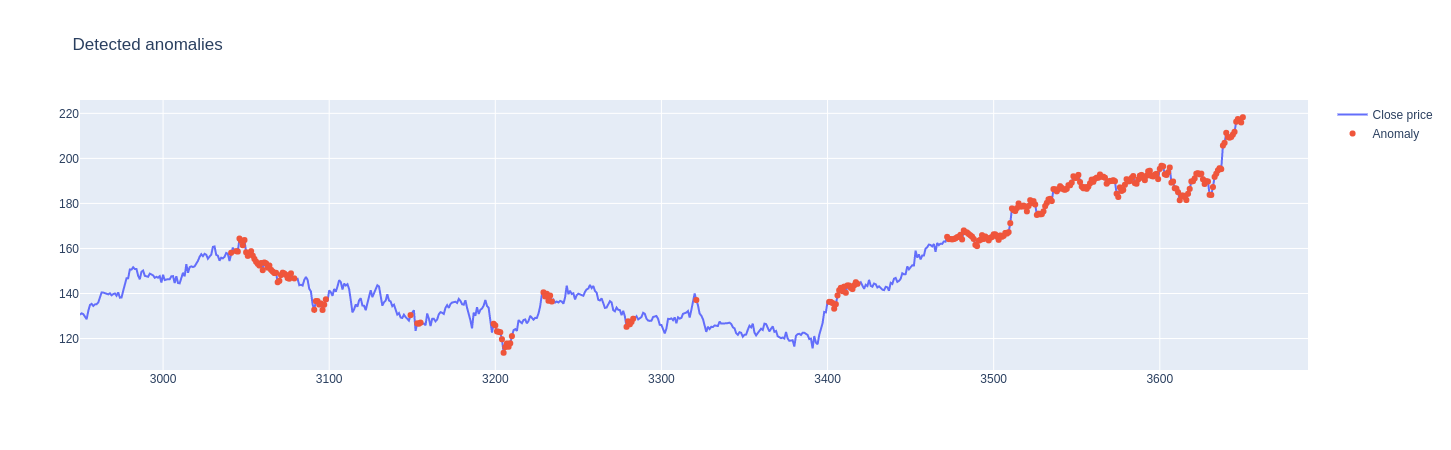

22/22 [==============================] - 0s 5ms/step - loss: 0.0950
0.0950227826833725


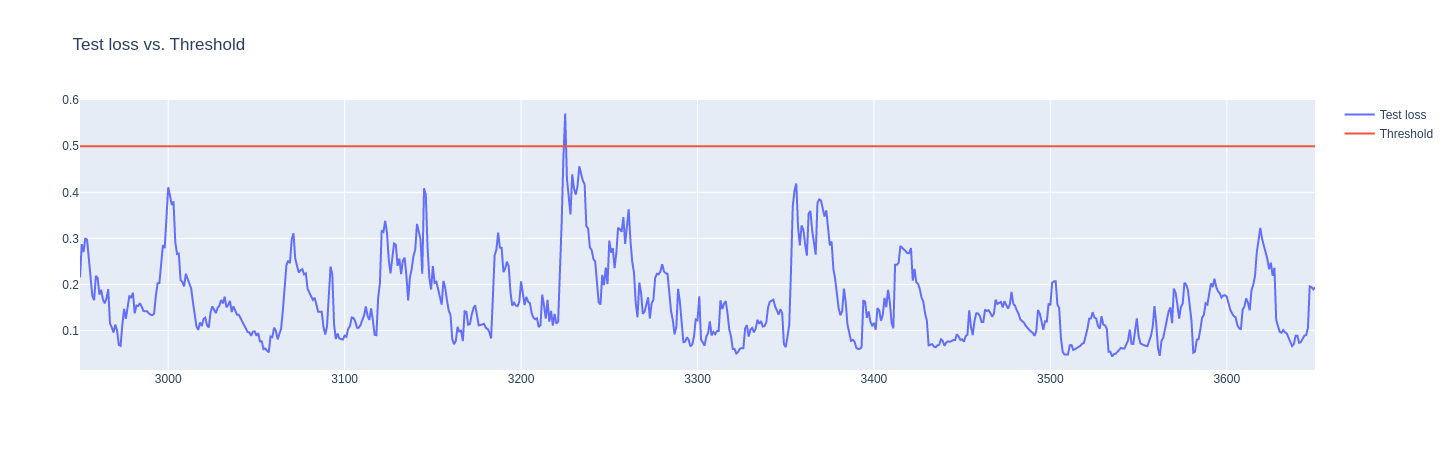

(1, 5)


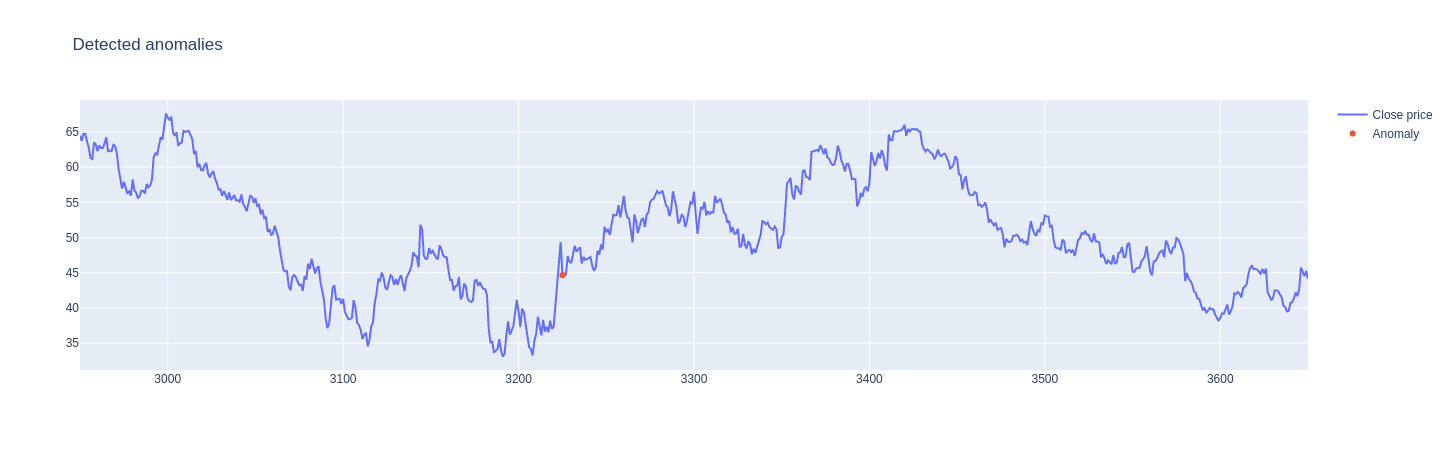

In [13]:
for k in range(0, n_predict):
    
    #Scale and calculate Test set
    test_set = df.iloc[first_80_percent:, k+1].values
    test_set=np.array(test_set)
    test_set=test_set.reshape(-1,1)
    test_set = scaler[k].transform(test_set)
    X_test, y_test = create_sequences(test_set, test_set)

    
    #Evaluate the model
    print(model.evaluate(X_test, y_test))

    #Predict and calculate test loss
    X_test_pred = model.predict(X_test, verbose=0)
    test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

    #Create a new dataframe with the required information
    test_set_date = df.loc[first_80_percent:, 'Date']
    test_score_df = pd.DataFrame(test_set_date[TIME_STEPS:])
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = threshold
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['Close'] = test_set[TIME_STEPS:]

    #Plot test loss
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
    fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
    fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
    fig.show()

    #Assign anomalies
    anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
    print(anomalies.shape)


    #Inverse transform test dataframe
    [tmp_test_score] = scaler[k].inverse_transform([np.array(test_score_df['Close'])])
    test_score_df['Close'] = tmp_test_score
    
    if len(anomalies.Close.value_counts()) > 0:
        [tmp_anomalies] = scaler[k].inverse_transform([np.array(anomalies['Close'])])
        anomalies.loc[:, 'Close'] = tmp_anomalies
    
    #Plot detected anomalies
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['Close'] , name='Close price'))
    fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['Close'], mode='markers', name='Anomaly'))
    fig.update_layout(showlegend=True, title='Detected anomalies')
    fig.show()